# Environment

In [14]:
!pip install gdown
!pip install tensorflow-macos==2.13
!pip install tensorflow-metal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.5 MB/s eta 0:00:004.6 MB/s eta 0:00:01


In [25]:
!gdown https://drive.google.com/uc?id=1rf-12hne2dpE1j4Li3h1t2dUPZIucbHp

Downloading...
From (original): https://drive.google.com/uc?id=1rf-12hne2dpE1j4Li3h1t2dUPZIucbHp
From (redirected): https://drive.google.com/uc?id=1rf-12hne2dpE1j4Li3h1t2dUPZIucbHp&confirm=t&uuid=6ff99301-6a56-411a-92e0-ba8347f16887
To: /home/easy/projects/transfer_learning/jserd_harmful_code_transfer_learning/cf_matrix.py
100%|██████████████████████████████████████| 4.09k/4.09k [00:00<00:00, 9.99MB/s]


In [26]:
!rm -rf /content/code_smells_datasets
!gdown --folder https://drive.google.com/drive/folders/1CcZmw-jwAc1Fc9LOgxYCSZPC0vQWjkXn?usp=drive_link
!cd /content/code_smells_datasets && tar -xvf train.tar && rm -rf train.tar
!cd /content/code_smells_datasets && tar -xvf test.tar && rm -rf test.tar

Retrieving folder contents
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Download completed
/bin/bash: line 1: cd: /content/code_smells_datasets: No such file or directory
/bin/bash: line 1: cd: /content/code_smells_datasets: No such file or directory


In [3]:
!mkdir -p content/models
!mkdir -p content/results
!mkdir -p content/results/confusion_matrix
!mkdir -p content/results/predictions

In [4]:
%run content/cf_matrix.py

# Research

In [12]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix
from numpy.random import seed

ModuleNotFoundError: No module named 'tensorflow.compat'

In [13]:
COMMENTS = [
    604,
    612,
    618,
    621,
    648
]
RANDOM_STATE = 33
LANGUAGES = ['Java', 'C#', 'C++', 'Python']
SMELLS = [
    {'name': 'HarmfulVsClean', 'suffix': 'hc', 'padding_tokens': 28191},
]

MAIN_DIR = 'content'
TRAIN_DIR = os.path.join(MAIN_DIR, 'code_smells_datasets', 'train')
TEST_DIR = os.path.join(MAIN_DIR, 'code_smells_datasets', 'test')
MODELS_DIR = os.path.join(MAIN_DIR, 'models')
RESULTS_DIR = os.path.join(MAIN_DIR, 'results')
DATA_FILE = os.path.join(RESULTS_DIR, 'data.csv')

# Helper functions

In [51]:
def to_array_int(token_str):
    return list(map(int, filter(len, token_str.split(' '))))

def padding_tokens(values, size):
    return pad_sequences(values, maxlen=size, padding='post', truncating='post')

def remove_comments(tokens):
    return list(filter(lambda value: value not in COMMENTS, tokens))

def pre_process_token_str(token_str):
    result = {}
    try:
      if type(token_str) == list:
        return remove_comments(token_str)
      result = remove_comments(to_array_int(token_str))
    except:
      print(token_str)
    return result

def init_data():
    return {
        'model': [],
        'dataset': [],
        'smell_name': [],
        'model_language': [],
        'target_language': [],
        'n_test_samples': [],
        'n_train_samples': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'tn': [],
        'fp': [],
        'fn': [],
        'tp': []
    }

def pad_data_dict(data):
    max_length = max(len(v) for v in data.values())
    for key, value in data.items():
        if len(value) < max_length:
            data[key].extend([None] * (max_length - len(value)))
    return data

def append_data_file(data):
    try:
        data = pad_data_dict(data)
        df = pd.DataFrame(data)
        df.to_csv(DATA_FILE, index=False, mode='a', header=not os.path.exists(DATA_FILE))
    except ValueError as ve:
        print(f"ValueError: {ve}")
        lengths = {k: len(v) for k, v in data.items()}
        print(f"Data lengths: {lengths}")
        raise
    except Exception as e:
        print(f"Unexpected error: {e}")
        raise

def select_samples(smell_csv, n_samples):
    dataset = pd.DataFrame(columns=['smell', 'tokens'])

    positive = smell_csv.query('smell == 1').sample(n_samples, random_state=RANDOM_STATE)
    negative = smell_csv.query('smell == 0').sample(n_samples, random_state=RANDOM_STATE)

    samples = pd.concat([positive, negative], axis=0)

    dataset['tokens'] = samples['tokens']
    dataset['smell'] = samples['smell']

    return dataset

def process(data, dataset_id, dataset, x, y, smell, languages, target_language, model_name2, model_n_sample_val=None):
    fig = plt.figure(figsize=(20, 5))
    i = 131

    for model_language in languages:
        if type(model_n_sample_val) == dict:
            model_n_sample = model_n_sample_val[smell['name']]
            model_n_sample = model_n_sample[model_language]
        else:
            model_n_sample = model_n_sample_val

        model_name = '{}_{}_{}_{}'.format(model_language, model_name2, model_n_sample, smell['suffix'])
        model_path = os.path.join(MODELS_DIR, model_name)

        if not os.path.exists(model_path):
            print('model not found: {}'.format(model_path))
            continue

        print('loading model: {}, dataset_id: {}'.format(model_name, dataset_id))
        
        pre_trained_model = load_model(model_path)

        loss, accuracy = pre_trained_model.evaluate(padding_tokens(x.values, smell['padding_tokens']), y, verbose=0)

        data['model'].append(model_name)
        data['n_train_samples'].append(model_n_sample)
        data['dataset'].append(dataset_id)
        data['smell_name'].append(smell['name'])
        data['model_language'].append(model_language)
        data['target_language'].append(target_language)
        data['n_test_samples'].append(len(x))
        data['accuracy'].append(accuracy)

        predictions = pre_trained_model.predict(padding_tokens(x.values, smell['padding_tokens']))
        output_name = 'model_{}_dataset_{}'.format(model_name, dataset_id)

        try:
            cf_matrix = confusion_matrix(y, (predictions > 0.5).astype("int32"))
            tn, fp, fn, tp = cf_matrix.ravel()
            precision = tp / (tp + fp)
            recall = tp / (tp + fn)
            f1 = 2 * (precision * recall) / (precision + recall)

            data['precision'].append(precision)
            data['recall'].append(recall)
            data['f1'].append(f1)
            data['tn'].append(tn)
            data['fp'].append(fp)
            data['fn'].append(fn)
            data['tp'].append(tp)

            fig.add_subplot(i)
            plt.title('{}: {} to {}'.format(smell['name'], model_language, target_language))

            make_confusion_matrix(cf_matrix,
                                  group_names=['TN', 'FP', 'FN', 'TP'],
                                  categories=['No', 'Yes'],
                                  sum_stats=False)



            dataset.loc[:, 'predict_value'] = predictions
            dataset.loc[:, 'predict_class'] = (predictions > 0.5).astype("int32")
        except Exception as e:
            print(e)
            data['precision'].append(0)
            data['recall'].append(0)
            data['f1'].append(0)
            print('Fail to build MF')

        dataset.to_csv(os.path.join(RESULTS_DIR, 'predictions', output_name))

        i = i + 1

    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix', 'model_{}_dataset_{}.png'.format(model_name, dataset_id)))
    plt.close()

## Exemple: to_array_int

In [52]:
to_array_int('300 200 100')

[300, 200, 100]

## Example: padding_tokens

In [53]:
tokens = [
    [300, 200, 100], # length < 5
    [300, 200, 100, 123, 123], # length = 5
    [300, 200, 100, 123, 123, 909, 123, 1923, 2813] # length > 5
]

padding_tokens(tokens, 5)

array([[300, 200, 100,   0,   0],
       [300, 200, 100, 123, 123],
       [300, 200, 100, 123, 123]], dtype=int32)

# RQ1: How effective is transfer learning to detect code smells?

## Functions

In [54]:
def perceptron(padding):
    np.random.seed(RANDOM_STATE)
    model = Sequential()
    model.add(Embedding(20000, 8, input_length=padding))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [55]:
def train_all_samples(languages, dataset_name, smell, model_function, model_name, model_n):
    for language in languages:

        print('training model: {} {} {} {}'.format(language, smell['name'], dataset_name, model_name))

        dataset_path = os.path.join(TRAIN_DIR, '{}_{}_{}.csv'.format(language, smell['name'], dataset_name))

        if not os.path.exists(dataset_path):
            print('train dataset not found: {} {}'.format(smell['name'], language))
            continue

        dataset = pd.read_csv(dataset_path, index_col=False, dtype = {'tokens': str})

        dataset['tokens'] = dataset['tokens'].map(lambda value: pre_process_token_str(value))

        x = dataset.iloc[:, -1]
        y = dataset.iloc[:, -2]

#         if os.path.exists(os.path.join(MODELS_DIR, '{}_{}_{}_{}'.format(language, model_name, len(x), smell['suffix']))):
#             print('model already exists')
#             continue

        x_train = padding_tokens(x.values, smell['padding_tokens'])
        y_train = y

        model = model_function(smell['padding_tokens'])

        model.fit(x_train, y_train, epochs=100, verbose=0)

        model.save(os.path.join(MODELS_DIR, '{}_{}_{}_{}'.format(language, model_name, len(x), smell['suffix'])))

        model_n[smell['name']].update({language: len(x)})

    else:
        return model_n

In [56]:
def transfer_learning(model_languages, target_language, model_name, model_n_sample):
    print('transfer learning: {} {}'.format(model_languages, target_language))

    data = init_data()

    for smell in SMELLS:
        print(smell['name'])
        for test in os.listdir(TEST_DIR):
            if test.startswith(target_language):
                dataset_path = os.path.join(TEST_DIR, test)
                dataset = pd.read_csv(os.path.join(dataset_path), index_col=False)

                dataset['tokens'] = dataset['tokens'].map(lambda value: pre_process_token_str(value))

                x = dataset.iloc[:, -1]
                y = dataset.iloc[:, -2]

                process(data, test, dataset, x, y, smell, model_languages, target_language, model_name, model_n_sample)

    return data

## Training Perceptron models

In [57]:
results = []
model_n_size = 64

for target_language in LANGUAGES:
    results.append(transfer_learning(LANGUAGES, target_language, 'perceptron1', model_n_size))

# for target_language in LANGUAGES:
#     results.append(transfer_learning(LANGUAGES, target_language, 'perceptron1', 64))

model_n_dict = {}
for smell in SMELLS:
    model_n_dict[smell['name']] = {}
    model_n_size = train_all_samples(LANGUAGES, 'Train_1', smell, perceptron, 'perceptron1', model_n_dict)

transfer learning: ['Java', 'C#', 'C++', 'Python'] Java
HarmfulVsClean
loading model: Java_perceptron1_64_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
model path: content/models/Java_perceptron1_64_hc


ValueError: File format not supported: filepath=content/models/Java_perceptron1_64_hc. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(content/models/Java_perceptron1_64_hc, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

<Figure size 1440x360 with 0 Axes>

## Transfer Learning

{'HarmfulVsClean': {'Java': 152, 'C#': 106, 'C++': 96, 'Python': 100}}
transfer learning: ['Java', 'C#', 'C++', 'Python'] Java
HarmfulVsClean
loading model: Java_perceptron1_152_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
loading model: C#_perceptron1_106_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
loading model: C++_perceptron1_96_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
loading model: Python_perceptron1_100_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 2ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
transfer learning: ['Java', 'C#', 'C++', 'Python'] C#
HarmfulVsClean
loading model: Java_perceptron1_152_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 29ms/step
loading model: C#_perceptron1_106_hc, dataset_id: C#_Har

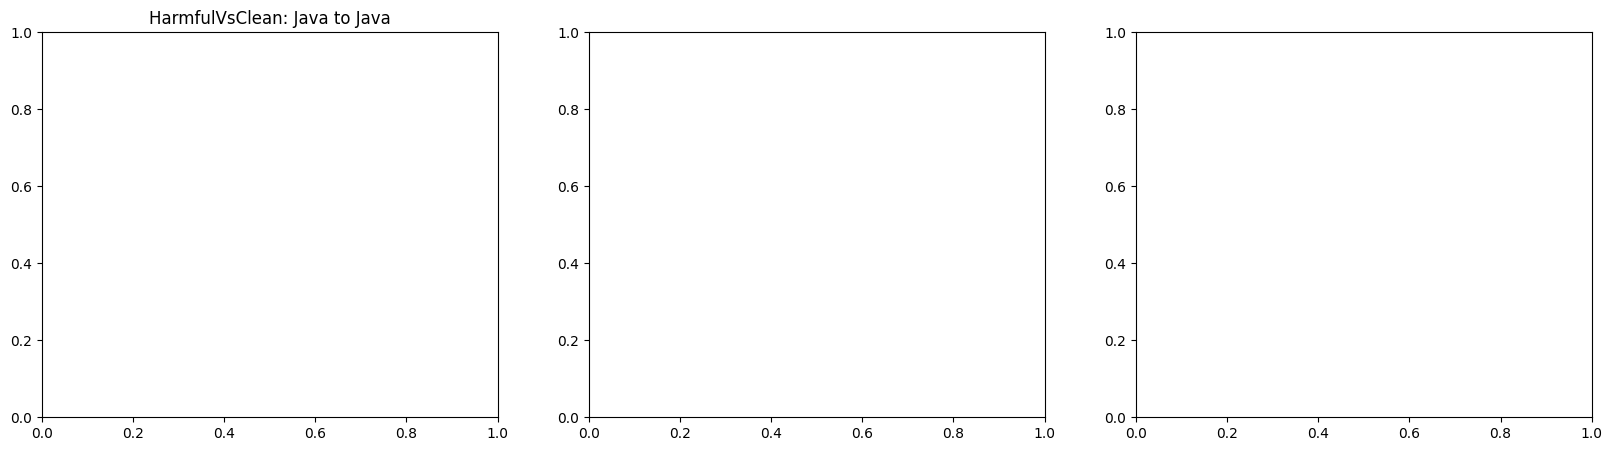

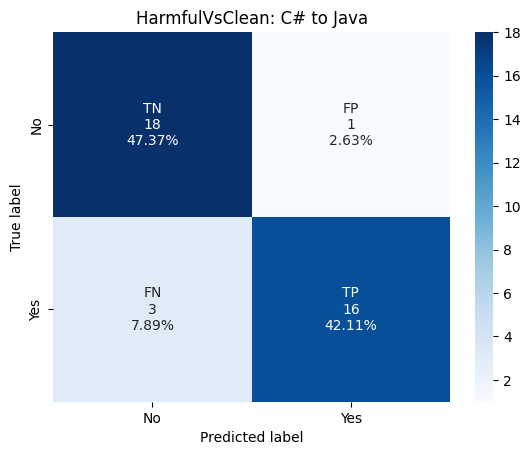

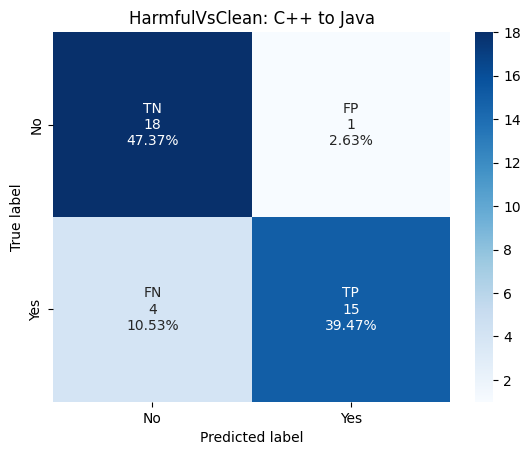

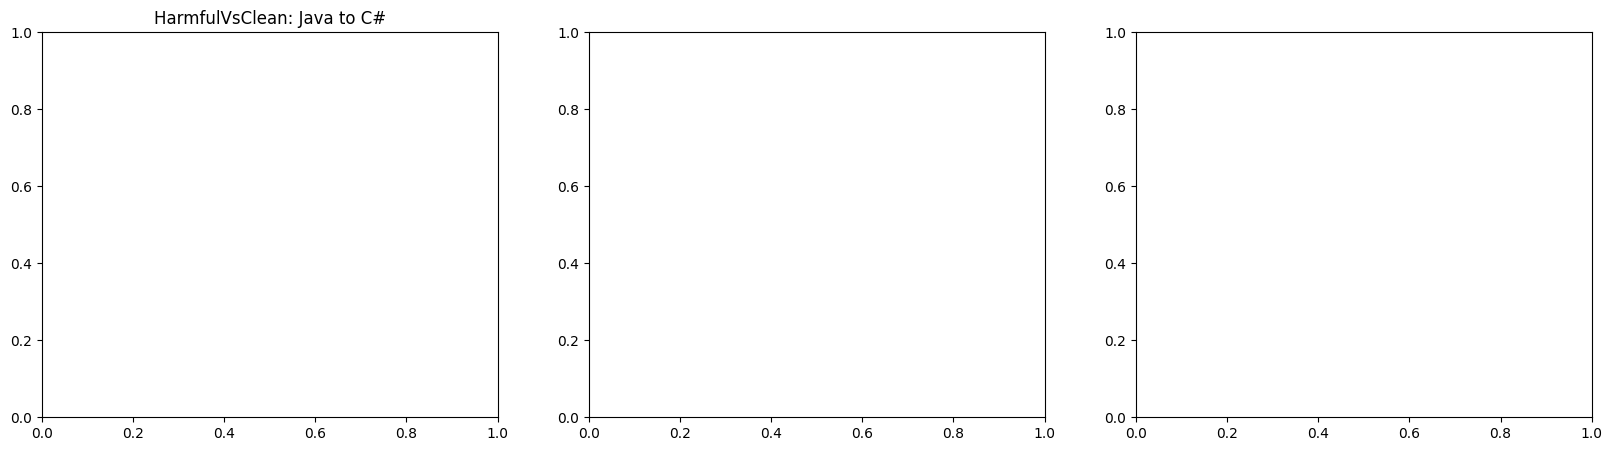

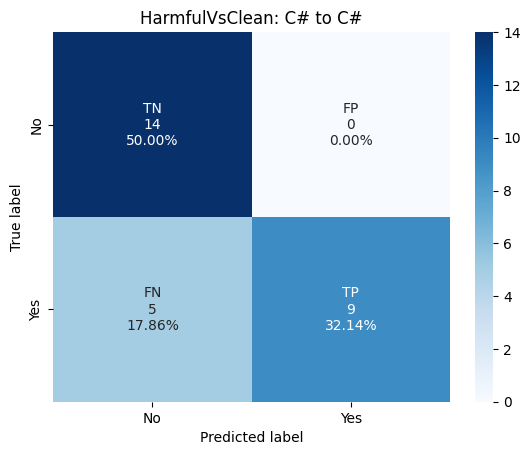

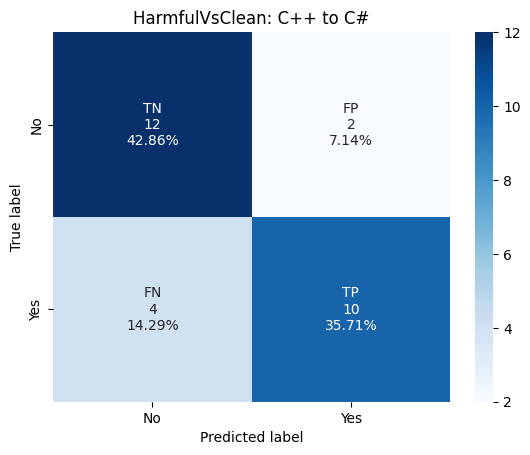

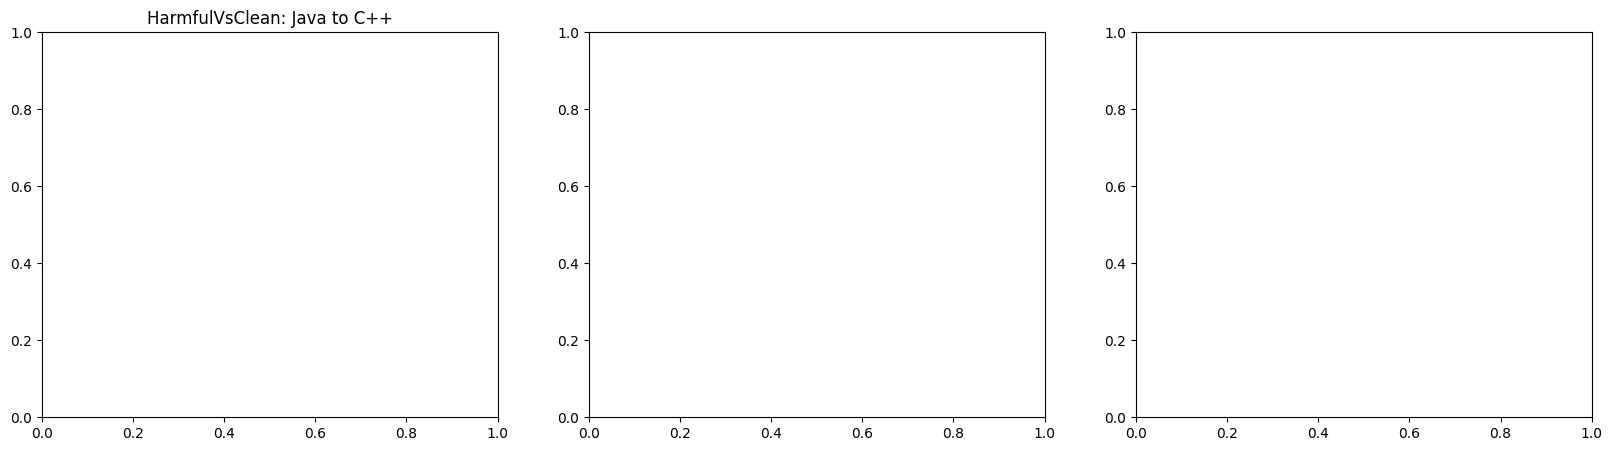

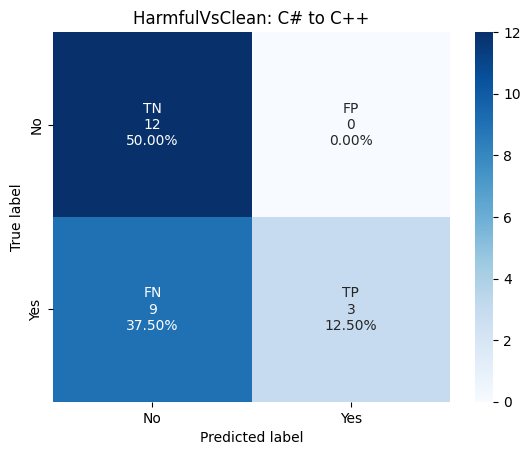

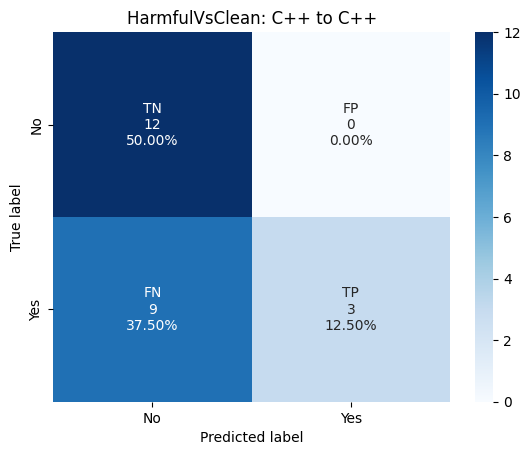

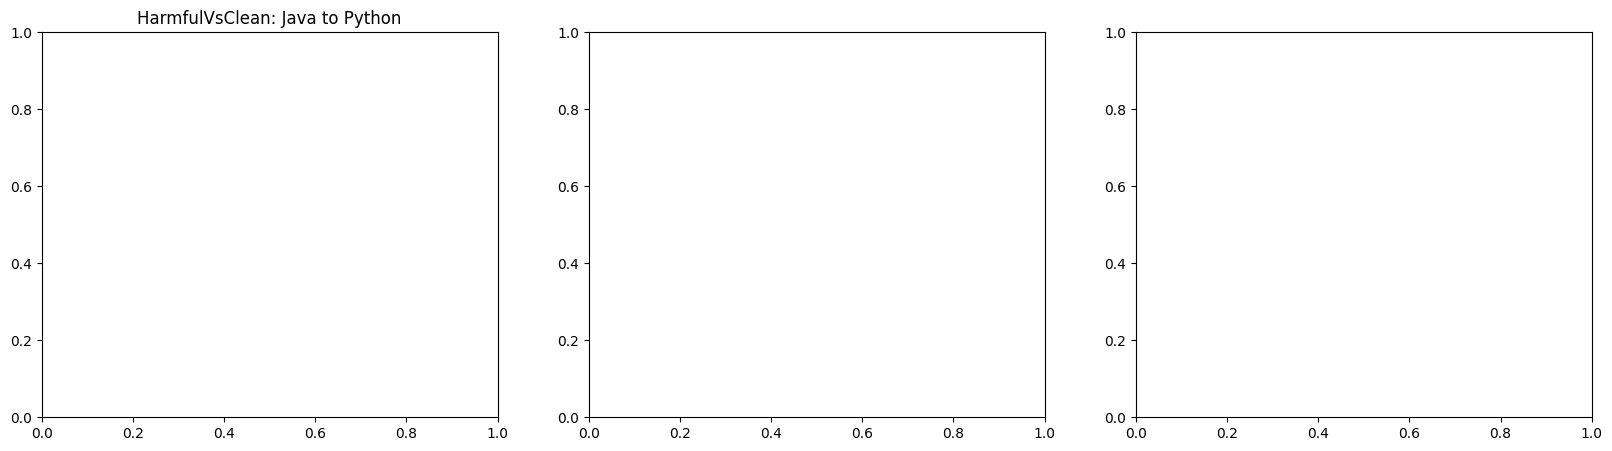

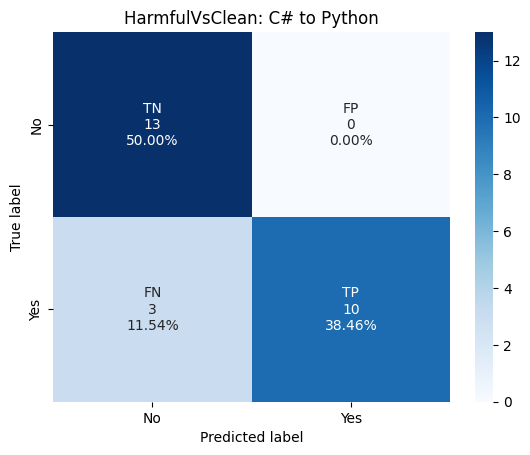

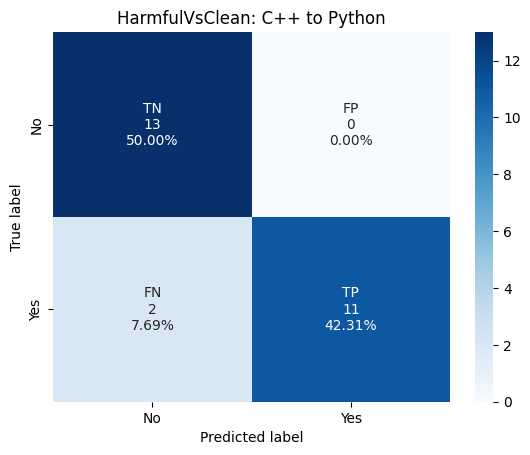

In [68]:
results = []
print(model_n_size)

for target_language in LANGUAGES:
    results.append(transfer_learning(LANGUAGES, target_language, 'perceptron1', model_n_size))

# for target_language in LANGUAGES:
#     results.append(transfer_learning(LANGUAGES, target_language, 'perceptron1', 64))

In [41]:
# Saving the results of those models when evaluated using Test datasets
for result in results:
    append_data_file(result)

# RQ2: How influential are programming languages constructs to detect code smells by using transfer learning?

In [42]:
dataset = pd.read_csv(os.path.join(RESULTS_DIR, 'data.csv'), index_col=False)
dataset = dataset.query("smell_name == 'HarmfulVsClean'", engine="python")
pd.set_option('display.max_rows', len(dataset) + 1)
dataset.sort_values(by=['f1'], ascending=True)

,model,dataset,smell_name,model_language,target_language,n_test_samples,n_train_samples,accuracy,precision,recall,f1,tn,fp,fn,tp
42,C#_perceptron1_16_hc,C#_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C#,C#,28.0,16.0,0.821429,0.000000,0.000000,0.000000,13.0,1.0,4.0,10.0
30,C++_perceptron1_32_hc,Java_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C++,Java,38.0,32.0,0.894737,0.000000,0.000000,0.000000,15.0,4.0,0.0,19.0
98,C++_cnn1_32_hc,Java_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C++,Java,38.0,32.0,0.500000,0.000000,0.000000,0.000000,0.0,19.0,0.0,19.0
132,C++_cnn1_32_hc,C++_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C++,C++,24.0,32.0,0.500000,0.000000,0.000000,0.000000,0.0,12.0,0.0,12.0
144,C#_cnn1_16_hc,Python_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C#,Python,10.0,16.0,0.800000,0.000000,0.000000,0.000000,5.0,0.0,2.0,3.0
25,C#_perceptron1_16_hc,Java_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C#,Java,38.0,16.0,0.842105,0.000000,0.000000,0.000000,18.0,1.0,5.0,14.0
47,C++_perceptron1_32_hc,C#_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C++,C#,28.0,32.0,0.714286,0.000000,0.000000,0.000000,8.0,6.0,2.0,12.0
122,Java_cnn1_8_hc,C++_HarmfulVsClean_Test_1.csv,HarmfulVsClean,Java,C++,24.0,8.0,0.625000,0.000000,0.000000,0.000000,12.0,0.0,9.0,3.0
54,Java_perceptron1_8_hc,C++_HarmfulVsClean_Test_1.csv,HarmfulVsClean,Java,C++,24.0,8.0,0.541667,0.000000,0.000000,0.000000,12.0,0.0,11.0,1.0
59,C#_perceptron1_16_hc,C++_HarmfulVsClean_Test_1.csv,HarmfulVsClean,C#,C++,24.0,16.0,0.583333,0.000000,0.000000,0.000000,12.0,0.0,10.0,2.0


# RQ3: How efficient is transfer learning to detect code smells?

## Functions

In [44]:
def train_n_samples(languages, n_samples, dataset_name, smell, model_function, model_name):
    for language in languages:
        for n in n_samples:
            name = '{}_{}_{}_{}'.format(language, model_name, n * 2, smell['suffix'])
            model_path = os.path.join(MODELS_DIR, name)

            if os.path.exists(model_path):
                continue

            print('training model (n samples): {} {} {} {} {}'.format(language, smell['name'], n * 2, dataset_name, model_name))

            dataset_path = os.path.join(TRAIN_DIR, '{}_{}_{}.csv'.format(language, smell['name'], dataset_name))

            if not os.path.exists(dataset_path):
                continue

            dataset = pd.read_csv(dataset_path)

            pos_smell_df = dataset.query('smell == 1')
            pos_size = len(pos_smell_df)
            neg_smell_df = dataset.query('smell == 0')
            neg_size = len(neg_smell_df)

            if pos_size < 2 * n or neg_size < 2 * n:
                print('Sample size too small, skipping')
                continue

            samples = select_samples(dataset, n)
            samples['tokens'] = samples['tokens'].map(lambda value: pre_process_token_str(value))

            x = samples.iloc[:, -1]
            y = samples.iloc[:, -2]

            x_train = padding_tokens(x.values, smell['padding_tokens'])
            y_train = y

            model = model_function(smell['padding_tokens'])

            model.fit(x_train, y_train, epochs=100, verbose=0)

            model.save(model_path)

def transfer_learning_n_samples(model_languages, target_language, dataset_name, smell, model_name):
    print('transfer learning (n samples): {} {} {}'.format(model_languages, target_language, smell['name']))

    data = init_data()

    for n in [4, 8, 16, 32, 64, 128, 256, 512]:
        tests = map(lambda t: t.format(target_language, smell['name'], dataset_name) + '.csv', [
            '{}_{}_{}',
        ])
        for test in tests:
            dataset_path = os.path.join(TEST_DIR, test)

            if not dataset_path:
                print('not exists', dataset_path)
                continue

            dataset = pd.read_csv(dataset_path, index_col=False)

            dataset['tokens'] = dataset['tokens'].map(lambda value: pre_process_token_str(value))

            x = dataset.iloc[:, -1]
            y = dataset.iloc[:, -2]

            process(data, test, dataset, x, y, smell, model_languages, target_language, model_name, n)

    return data


## Training Perceptron models

In [45]:
# train_n_samples(['Python'], [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', SMELLS[0], perceptron, 'perceptron1')
for smell in SMELLS:
    train_n_samples(LANGUAGES, [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', smell, perceptron, 'perceptron1')

training model (n samples): Java HarmfulVsClean 4 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Java_perceptron1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_perceptron1_4_hc/assets


training model (n samples): Java HarmfulVsClean 8 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Java_perceptron1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_perceptron1_8_hc/assets


training model (n samples): Java HarmfulVsClean 16 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Java_perceptron1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_perceptron1_16_hc/assets


training model (n samples): Java HarmfulVsClean 32 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Java_perceptron1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_perceptron1_32_hc/assets


training model (n samples): Java HarmfulVsClean 64 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Java_perceptron1_64_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_perceptron1_64_hc/assets


training model (n samples): Java HarmfulVsClean 128 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): Java HarmfulVsClean 256 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): Java HarmfulVsClean 512 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 4 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C#_perceptron1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_perceptron1_4_hc/assets


training model (n samples): C# HarmfulVsClean 8 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C#_perceptron1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_perceptron1_8_hc/assets


training model (n samples): C# HarmfulVsClean 16 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C#_perceptron1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_perceptron1_16_hc/assets


training model (n samples): C# HarmfulVsClean 32 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C#_perceptron1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_perceptron1_32_hc/assets


training model (n samples): C# HarmfulVsClean 64 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 128 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 256 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 512 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 4 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C++_perceptron1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_perceptron1_4_hc/assets


training model (n samples): C++ HarmfulVsClean 8 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C++_perceptron1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_perceptron1_8_hc/assets


training model (n samples): C++ HarmfulVsClean 16 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C++_perceptron1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_perceptron1_16_hc/assets


training model (n samples): C++ HarmfulVsClean 32 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/C++_perceptron1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_perceptron1_32_hc/assets


training model (n samples): C++ HarmfulVsClean 64 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 128 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 256 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 512 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 4 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Python_perceptron1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_perceptron1_4_hc/assets


training model (n samples): Python HarmfulVsClean 8 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Python_perceptron1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_perceptron1_8_hc/assets


training model (n samples): Python HarmfulVsClean 16 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Python_perceptron1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_perceptron1_16_hc/assets


training model (n samples): Python HarmfulVsClean 32 Train_1 perceptron1
INFO:tensorflow:Assets written to: content/models/Python_perceptron1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_perceptron1_32_hc/assets


training model (n samples): Python HarmfulVsClean 64 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 128 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 256 Train_1 perceptron1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 512 Train_1 perceptron1
Sample size too small, skipping


## Transfer Learning

transfer learning (n samples): ['Java', 'C#', 'C++', 'Python'] Java HarmfulVsClean
loading model: Java_perceptron1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 2ms/step
loading model: C#_perceptron1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


2/2 [==============================] - 0s 3ms/step
loading model: C++_perceptron1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
loading model: Python_perceptron1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


2/2 [==============================] - 0s 2ms/step
loading model: C#_perceptron1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
loading model: C++_perceptron1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 2ms/step
loading model: Python_perceptron1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 2ms/step
loading model: C#_perceptron1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 2ms/step
loading model: C++_perceptron1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 3ms/step
loading model: Python_perceptron1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [===

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 28ms/step
loading model: C++_perceptron1_4_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 35ms/step
loading model: Python_perceptron1_4_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 34ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_8_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 30ms/step
loading model: C#_perceptron1_8_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 29ms/step
loading model: C++_perceptron1_8_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 30ms/step
loading model: Python_perceptron1_8_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 28ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron

/home/easy/projects/transfer_learning/jserd_harmful_code_transfer_learning/content/cf_matrix.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


1/1 [==============================] - 0s 28ms/step
loading model: C++_perceptron1_16_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 29ms/step
loading model: Python_perceptron1_16_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 27ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 29ms/step
loading model: C#_perceptron1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 27ms/step
loading model: C++_perceptron1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 34ms/step
loading model: Python_perceptron1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 31ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perc

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 28ms/step
loading model: C++_perceptron1_4_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 29ms/step
loading model: Python_perceptron1_4_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 28ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 29ms/step
loading model: C#_perceptron1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 32ms/step
loading model: C++_perceptron1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 32ms/step
loading model: Python_perceptron1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 31ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 28ms/step
loading model: C#_perceptron1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 38ms/step
loading model: C++_perceptron1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 30ms/step
loading model: Python_perceptron1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 31ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_32_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 29ms/step
loading model: C#_perceptron1_32_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 28ms/step
loading model: C++_perceptron1_32_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 30ms/step
loading model: Python_perceptron1_32_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 29ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_64_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 31ms/step
model not found: content/models/C#_perceptron1_64_hc
model not found: content/models/C++_perceptron1_64_hc
model not found: content/models/Python_perceptron1_64_hc
model not found: content/models/Java_perceptron1_128_hc
model not found: content/models/C#_perceptron1_128_hc
model not found: content/models/C++_perceptron1_128_hc
model not found: content/models/Python_perceptron1_128_hc
model not found: content/models/Java_perceptron1_256_hc
model not found: content/models/C#_perceptron1_256_hc
model not found: content/models/C++_perceptron1_256_hc
model not found: content/models/Python_perceptron1_256_hc
model not found: content/models/Java_perceptron1_512_hc
model not found: content/models/C#_perceptron1_512_hc
model not found: content/models/C++_perceptron1_512_hc
model not found: content/models/Python_perceptron1_512_hc
transfer learning (n samples): ['Java', 'C#', 'C++', 'Python'] Python HarmfulVsClean
loading model: Java_perceptron

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 28ms/step
loading model: C++_perceptron1_4_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 28ms/step
loading model: Python_perceptron1_4_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 27ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 28ms/step
loading model: C#_perceptron1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 35ms/step
loading model: C++_perceptron1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 34ms/step
loading model: Python_perceptron1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 28ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 30ms/step
loading model: C#_perceptron1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 29ms/step
loading model: C++_perceptron1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 27ms/step
loading model: Python_perceptron1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 28ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_perceptron1_32_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 31ms/step


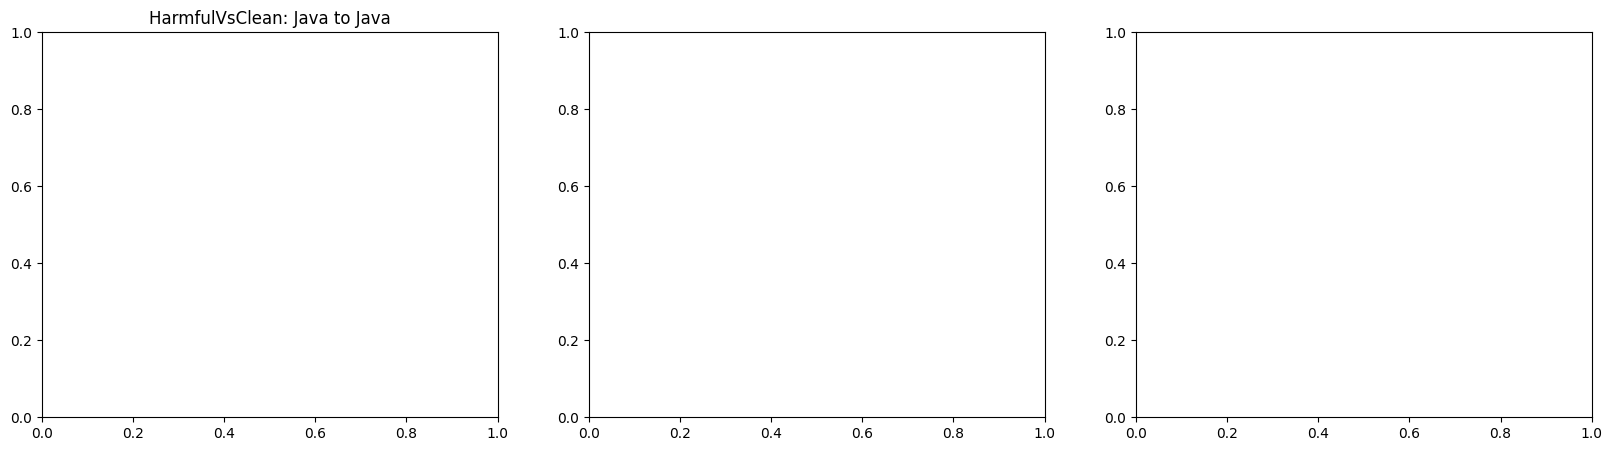

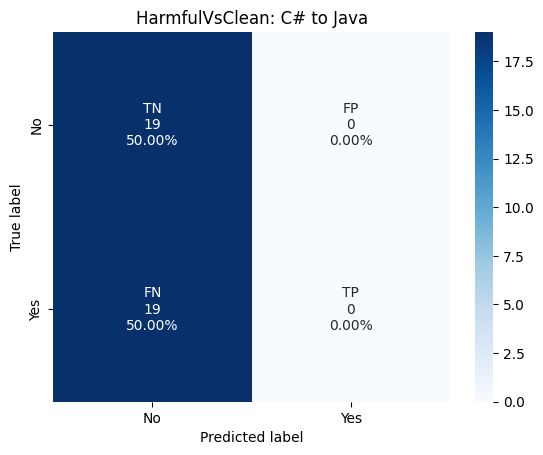

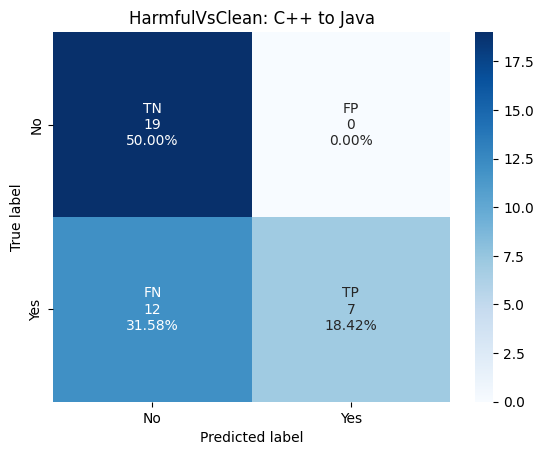

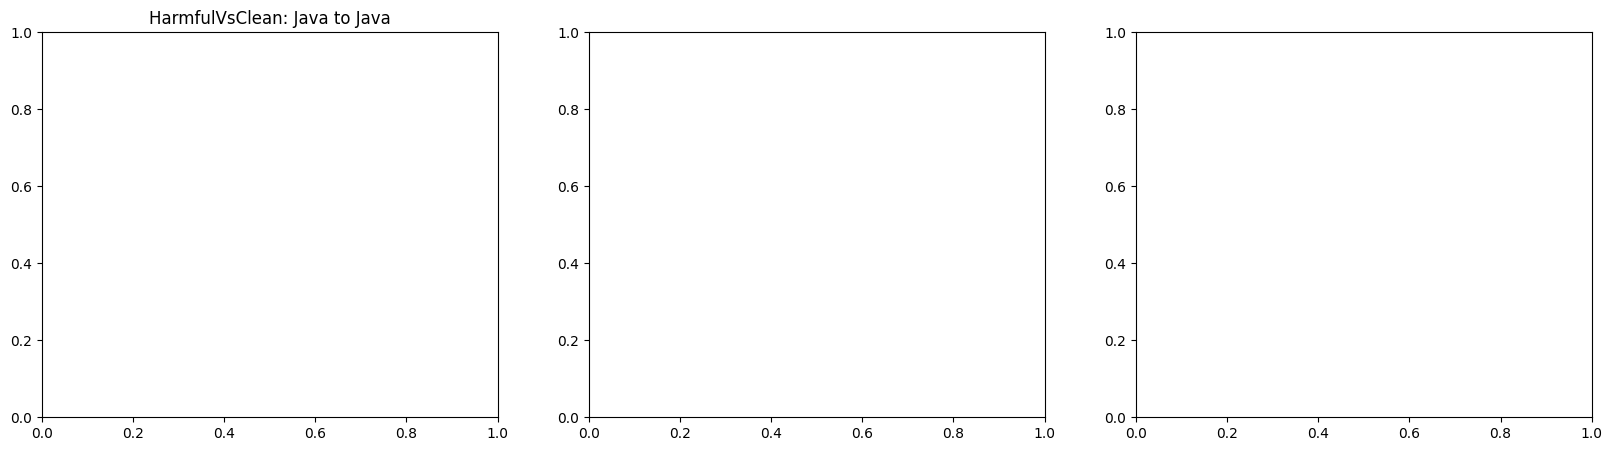

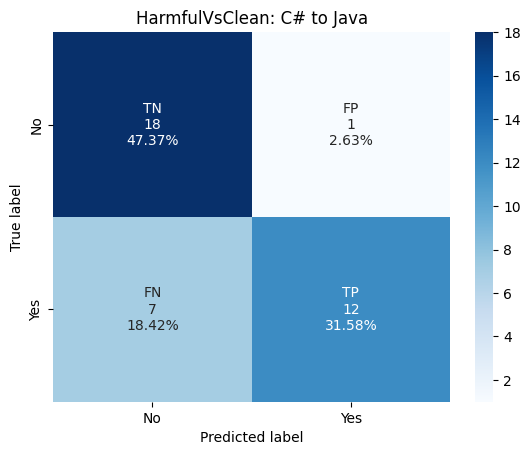

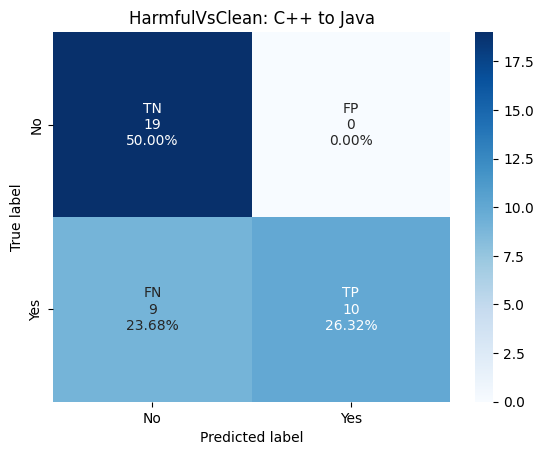

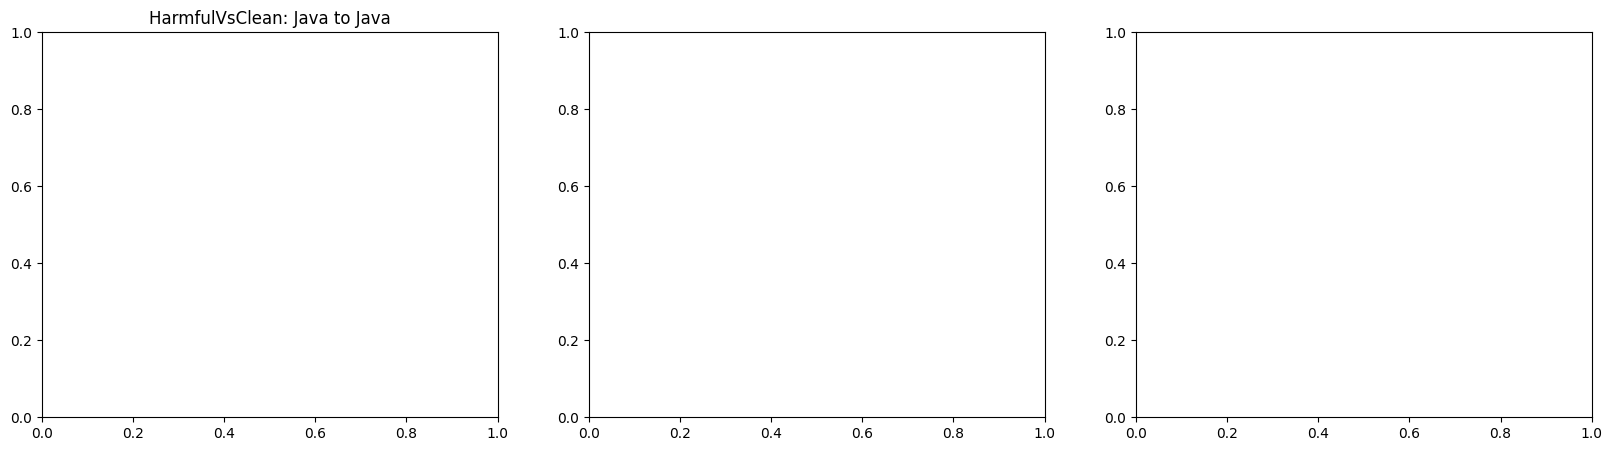

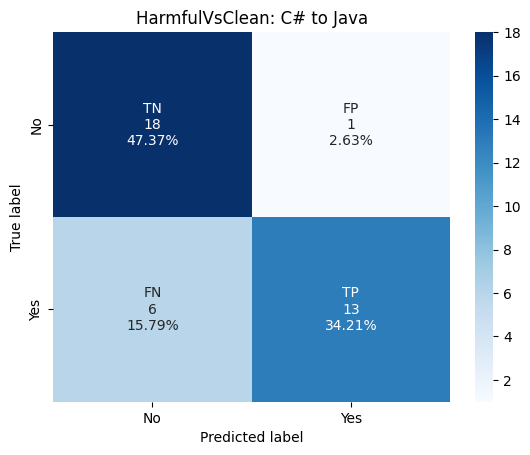

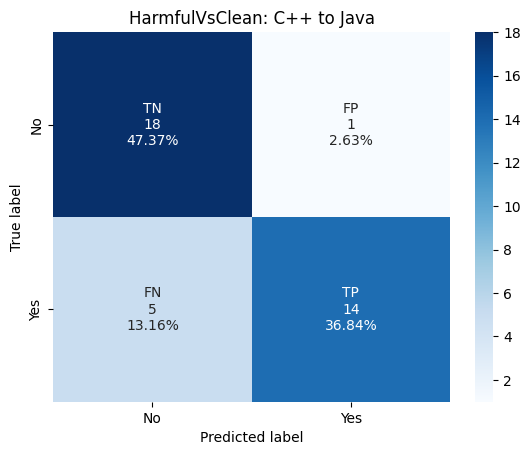

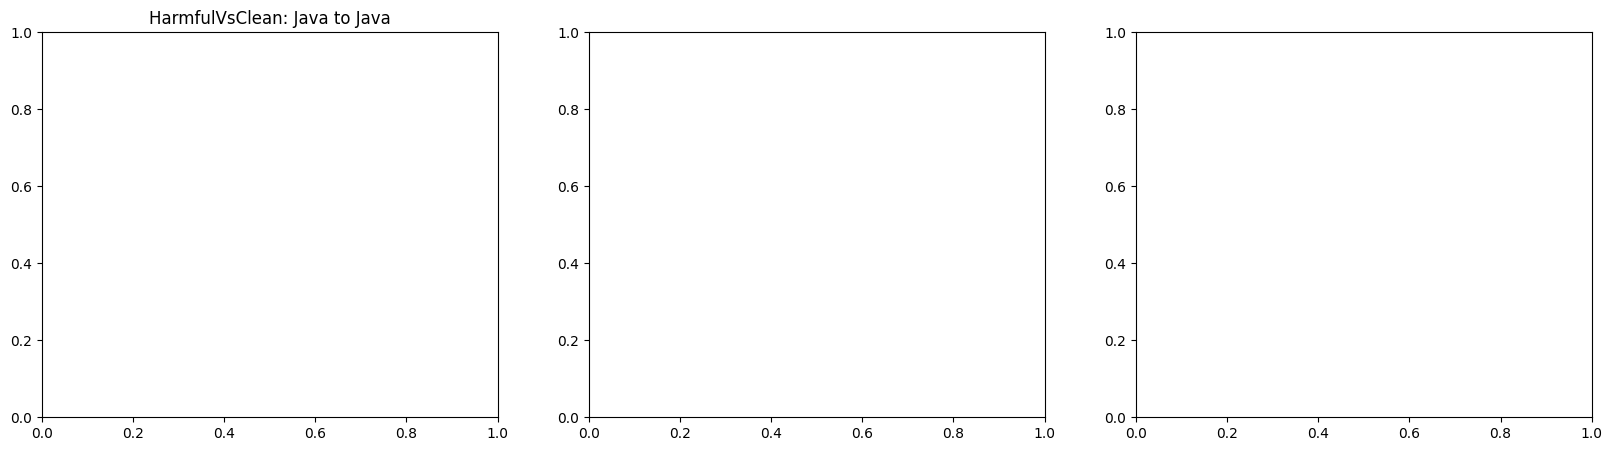

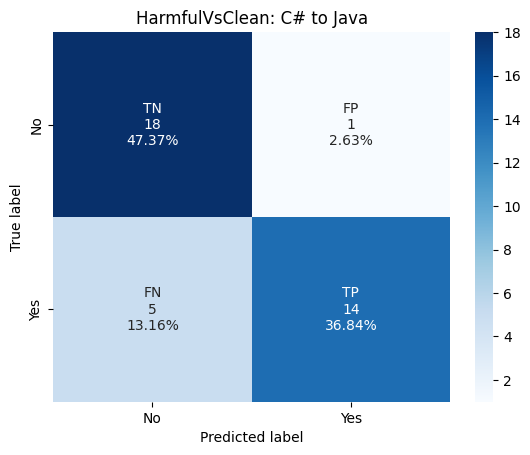

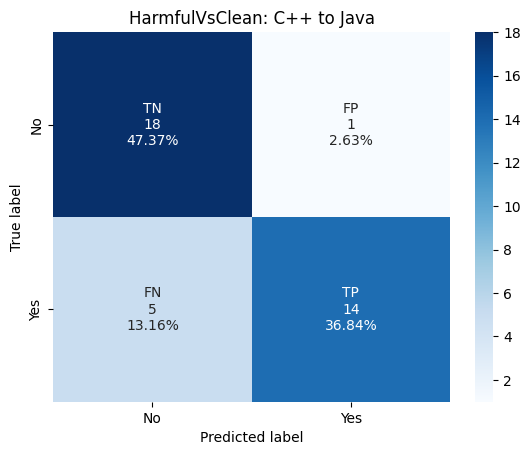

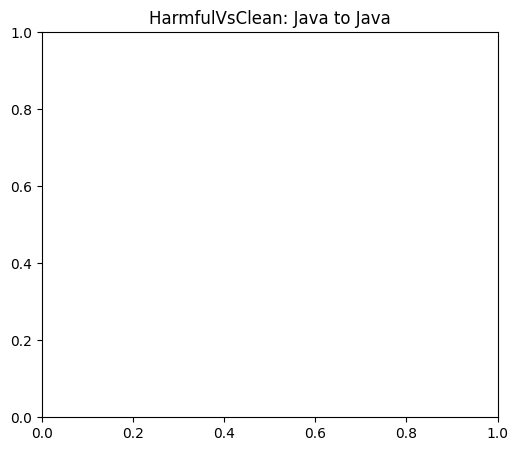

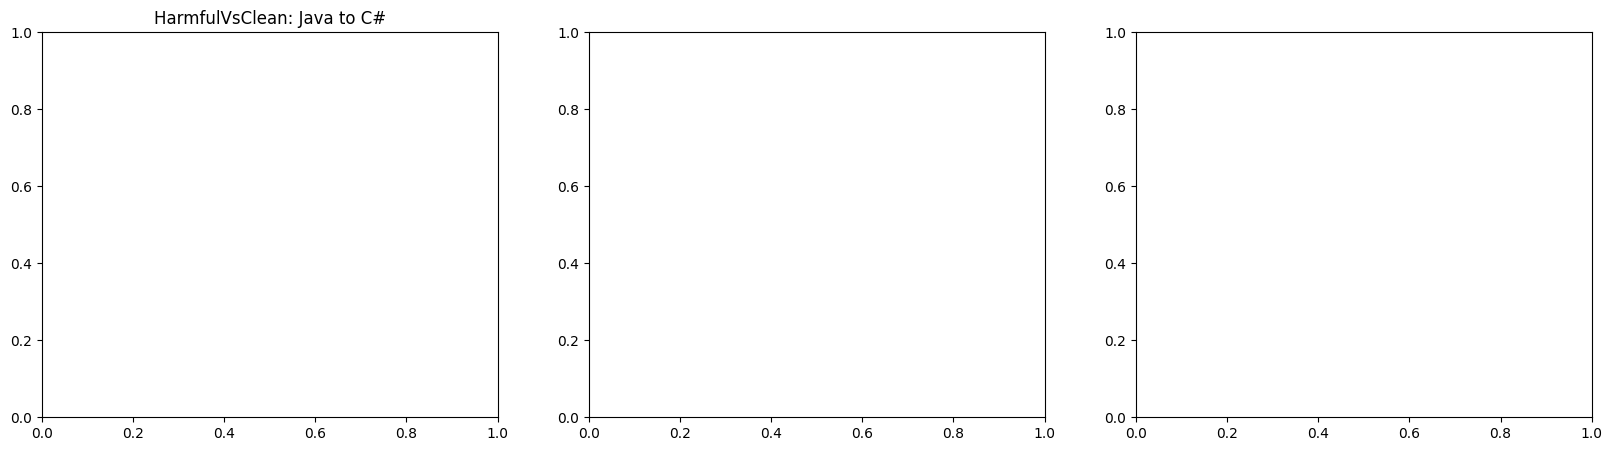

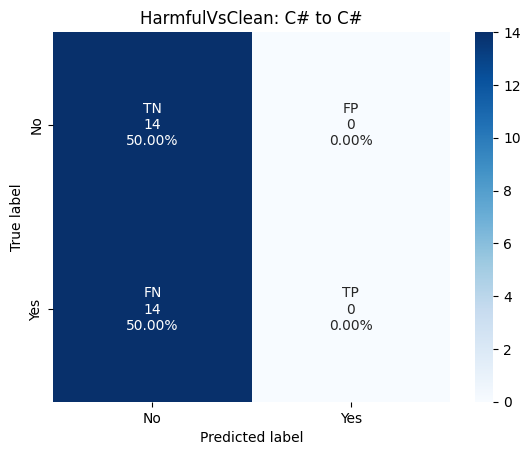

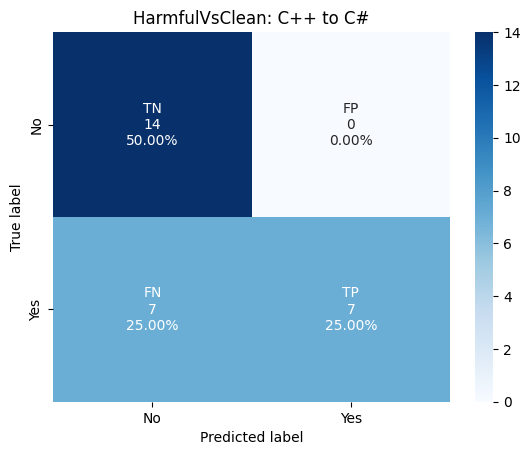

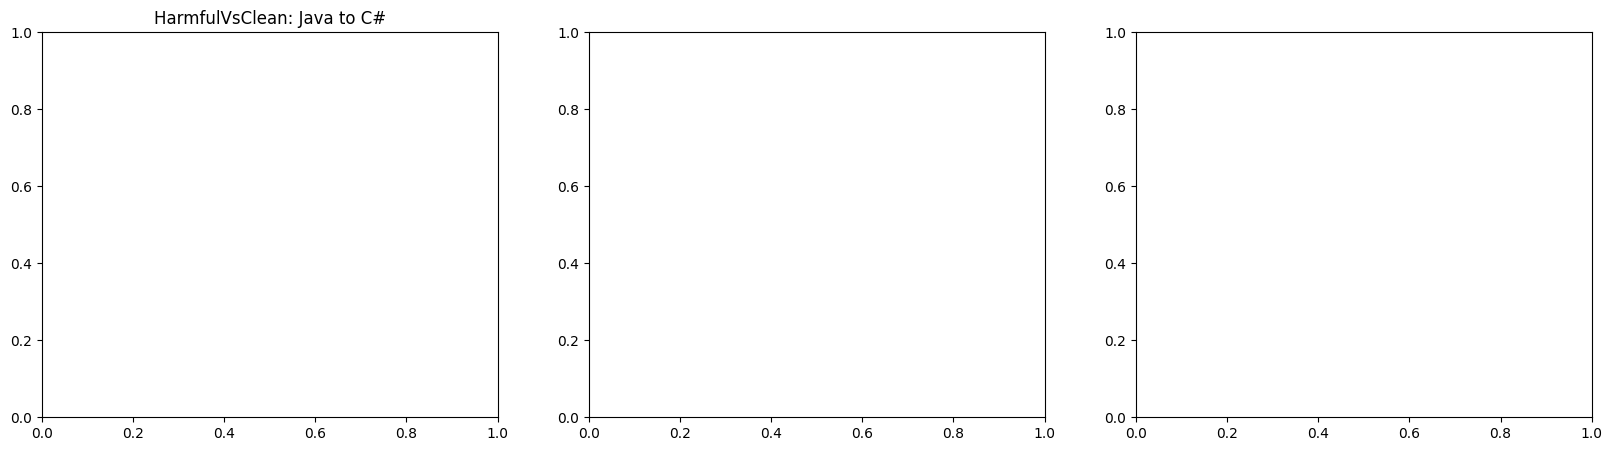

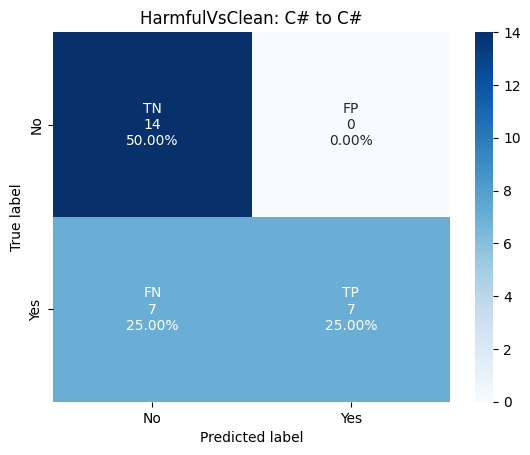

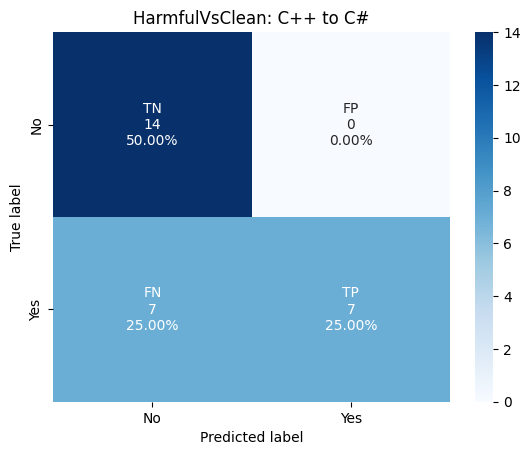

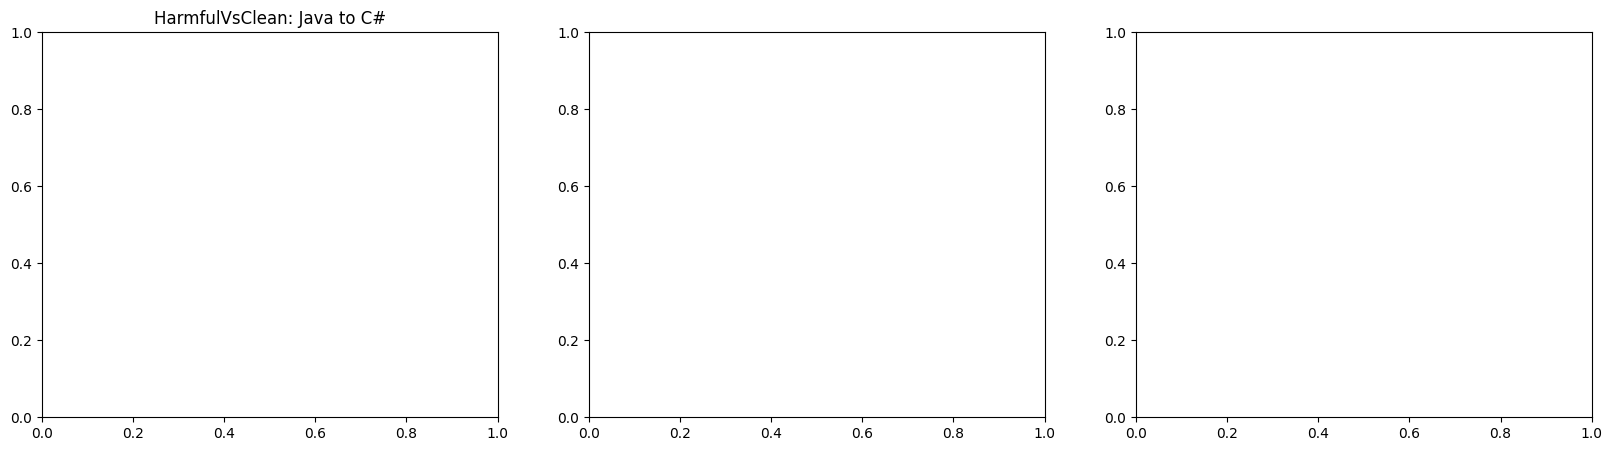

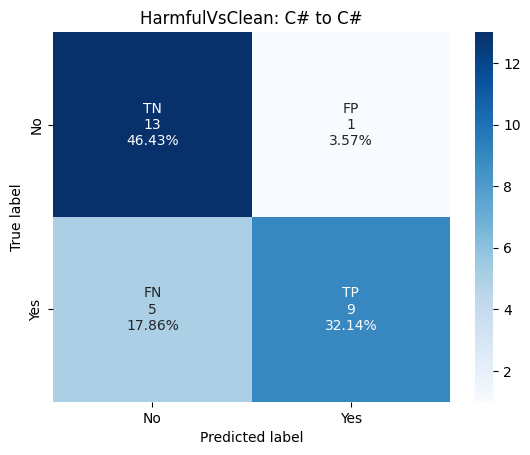

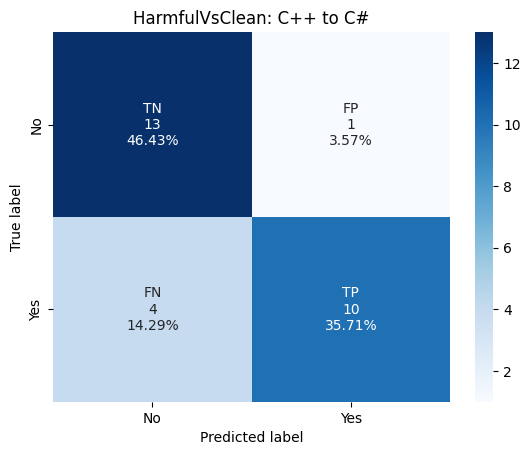

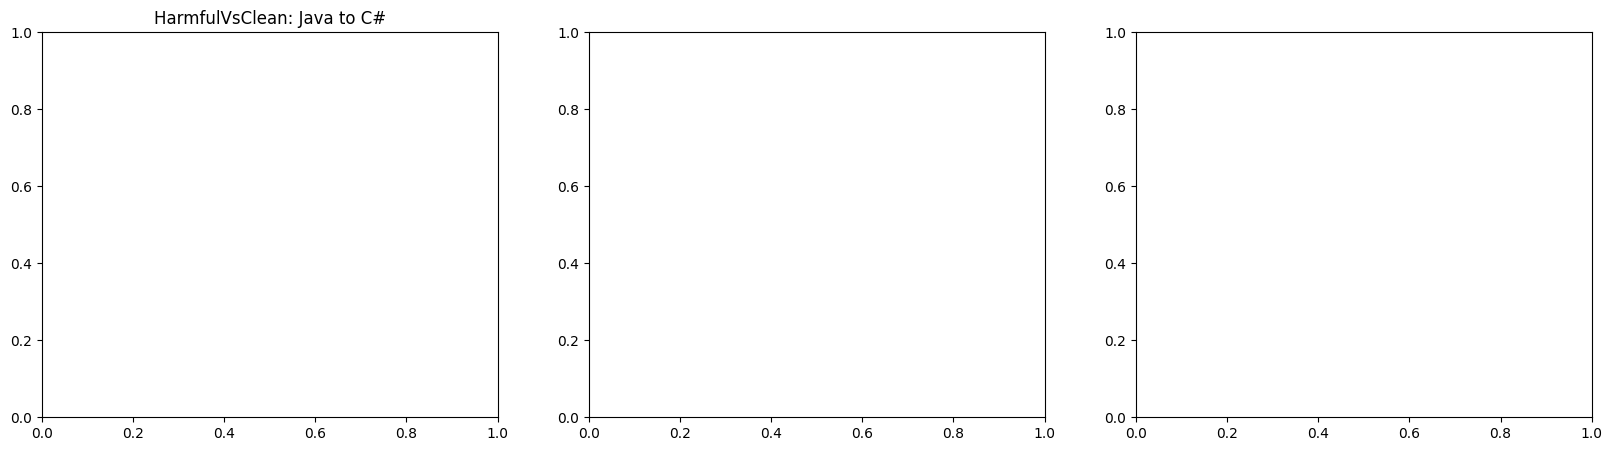

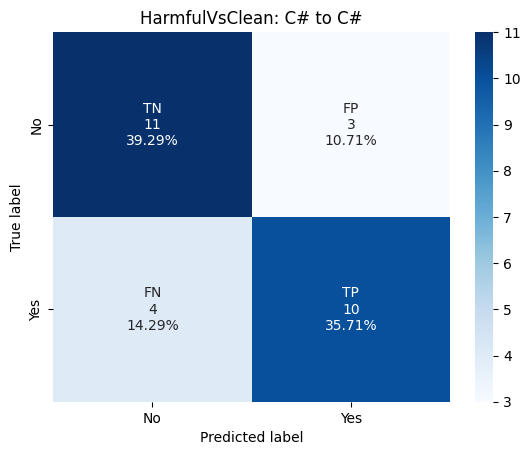

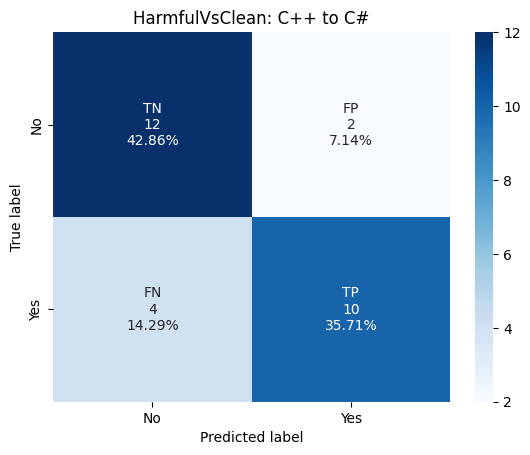

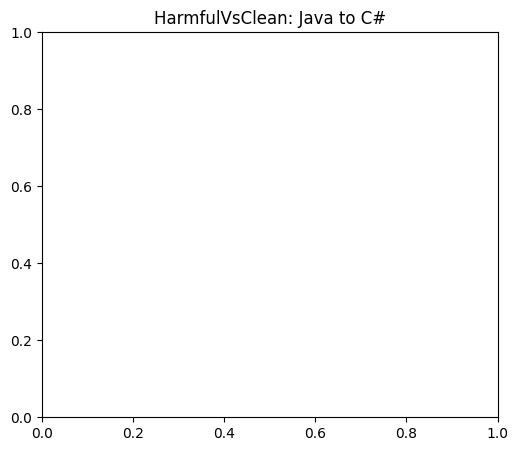

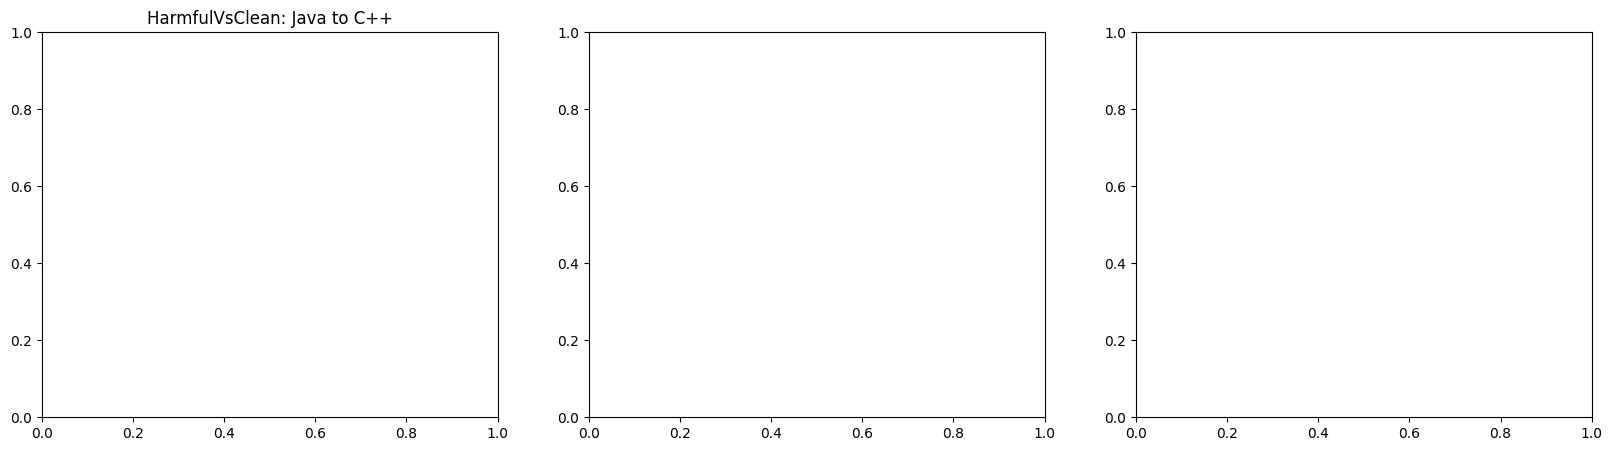

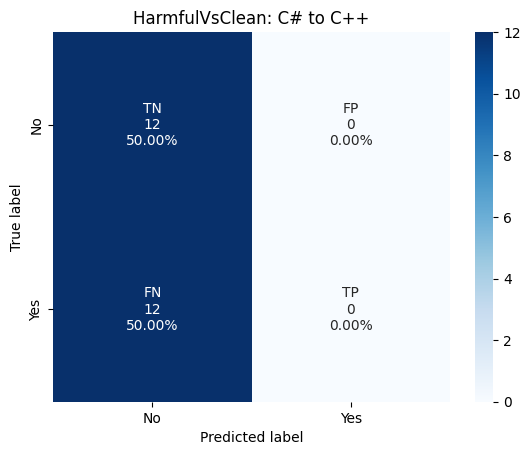

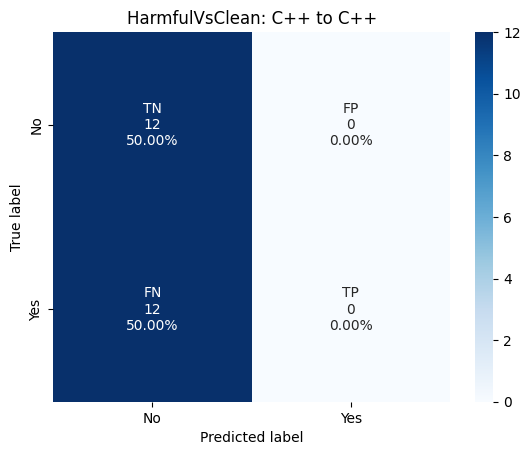

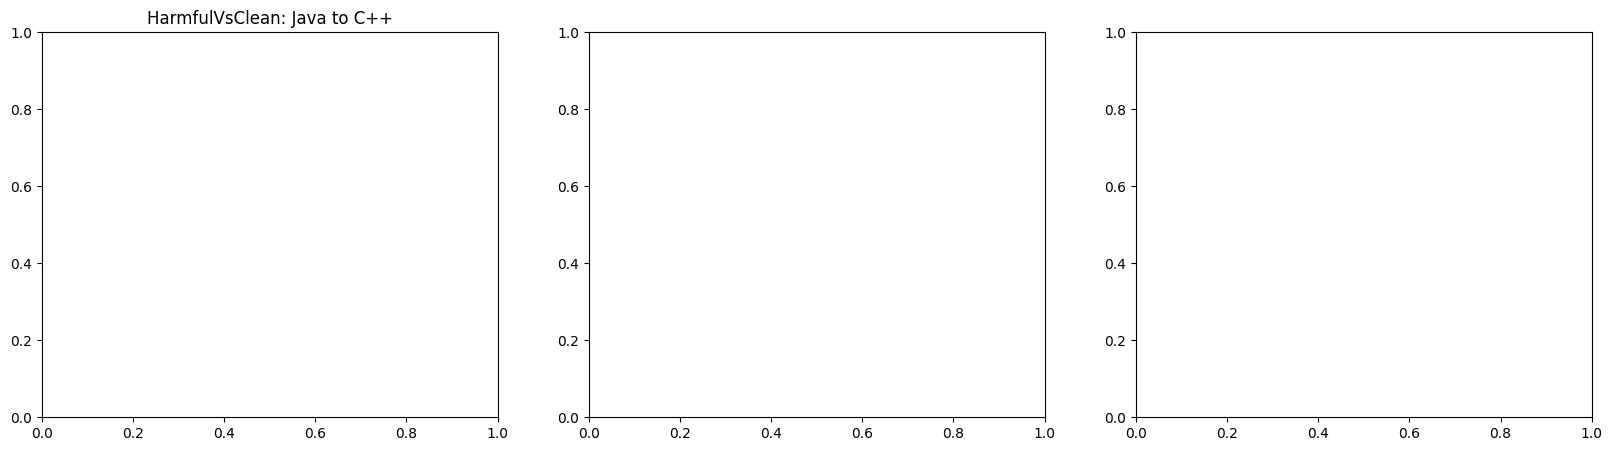

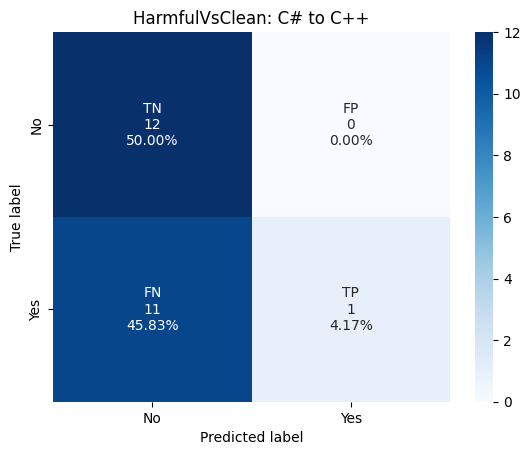

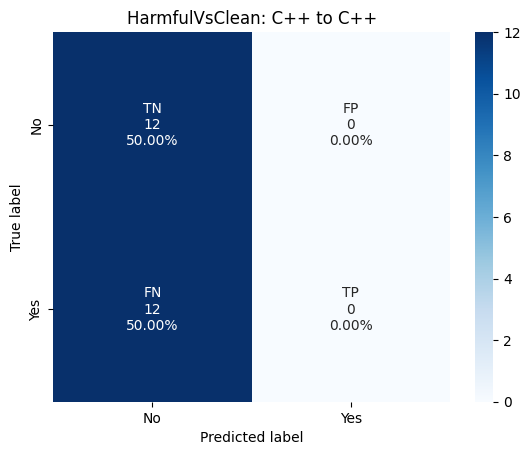

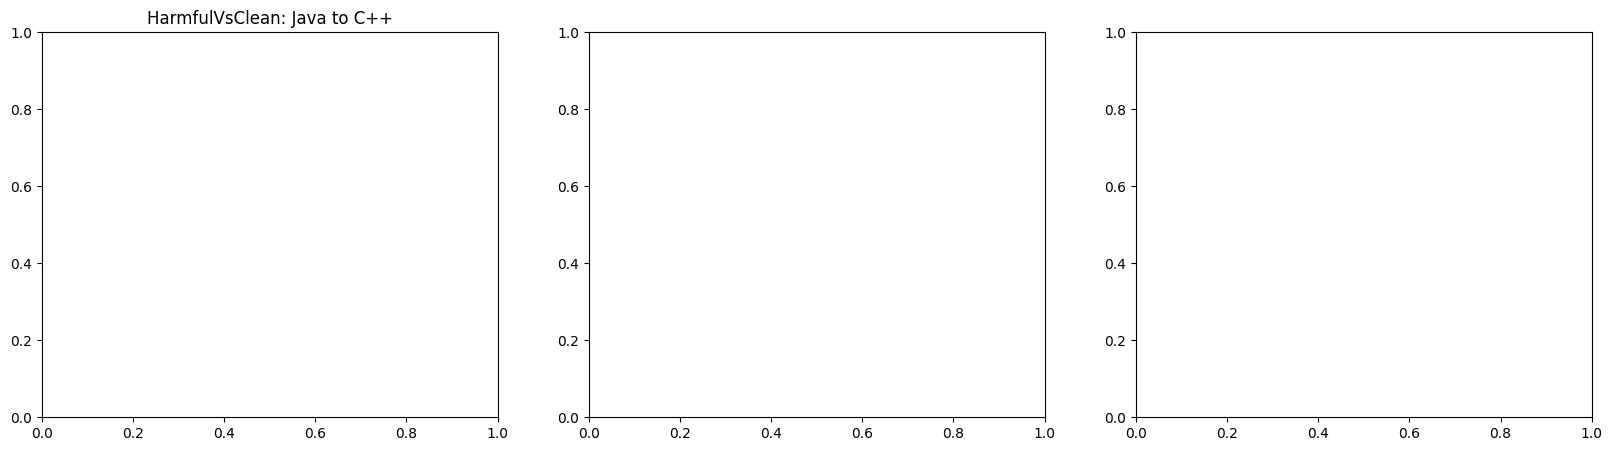

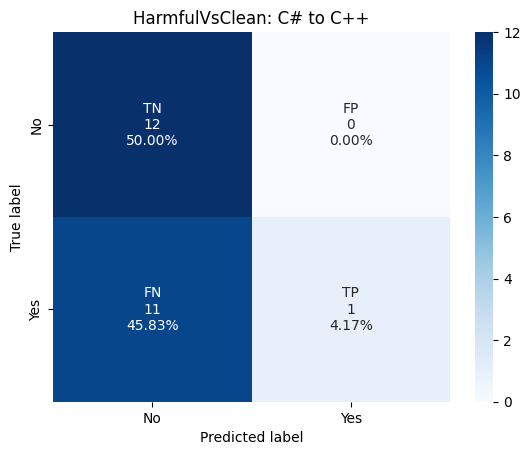

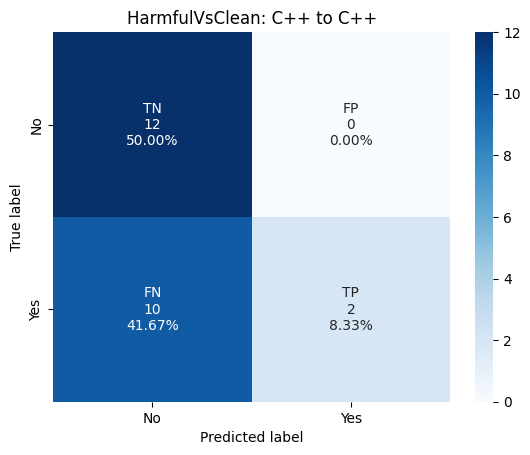

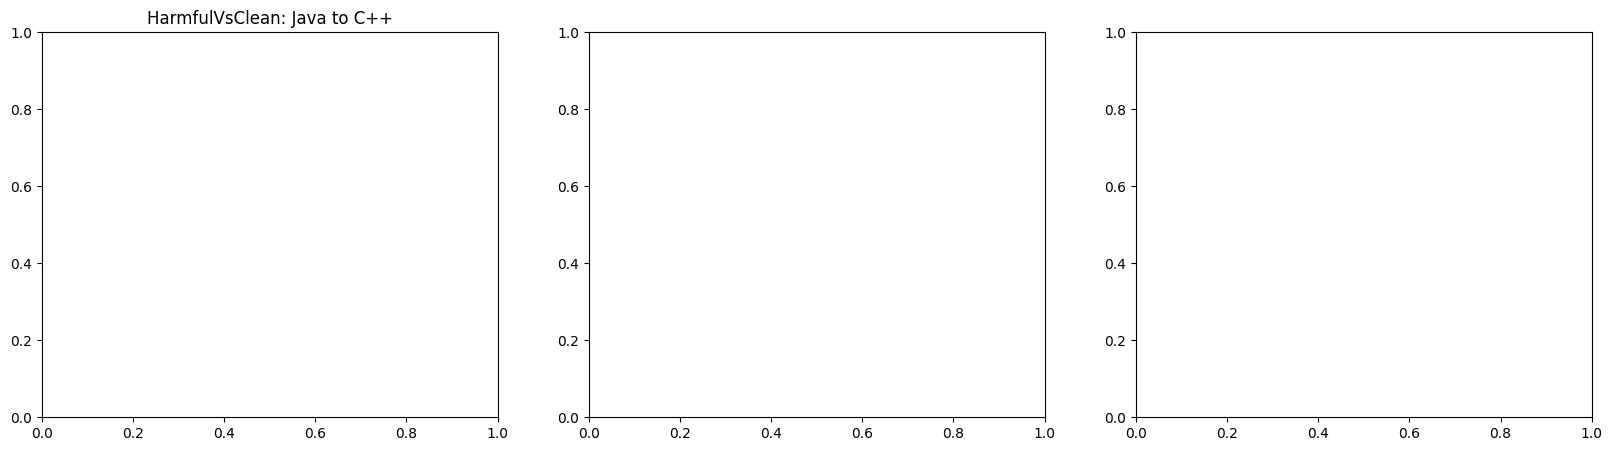

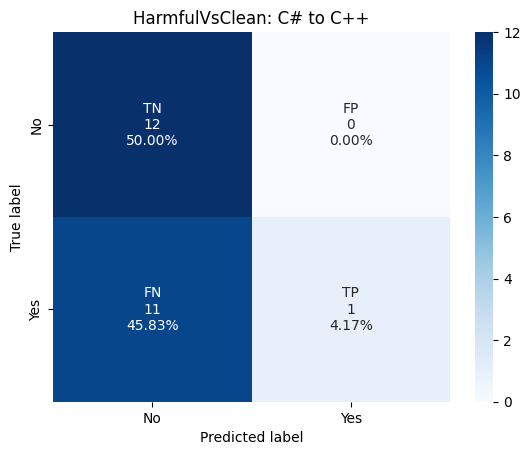

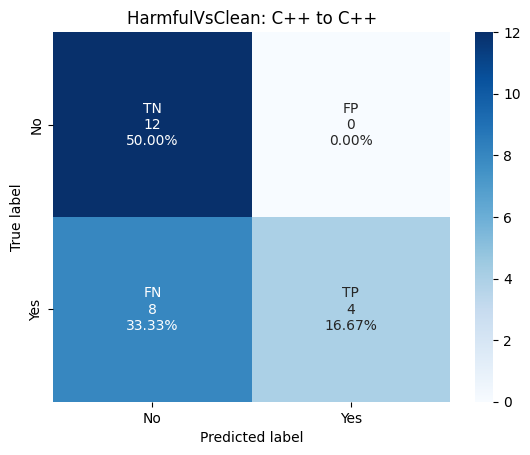

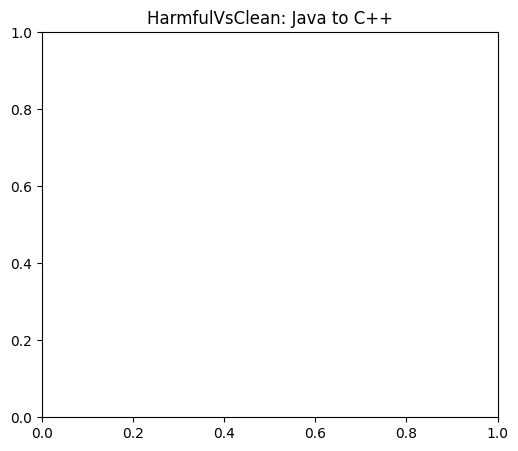

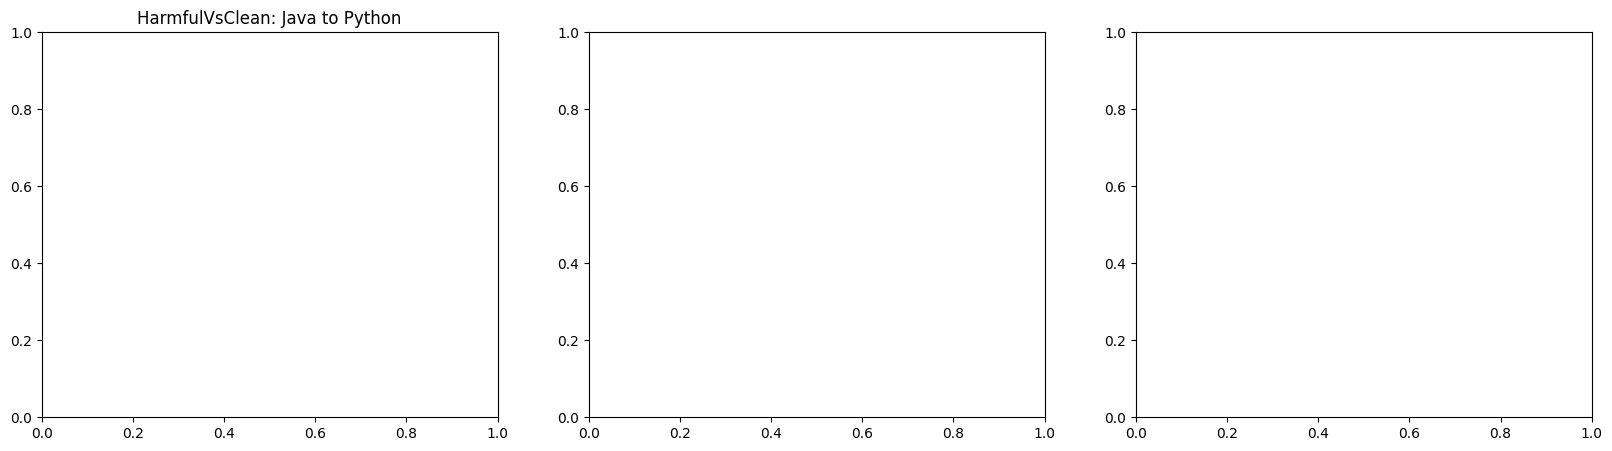

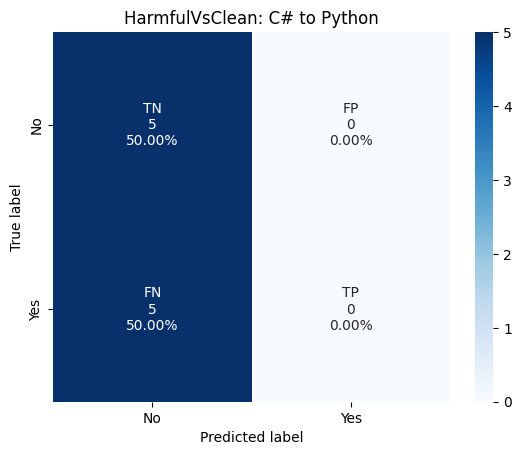

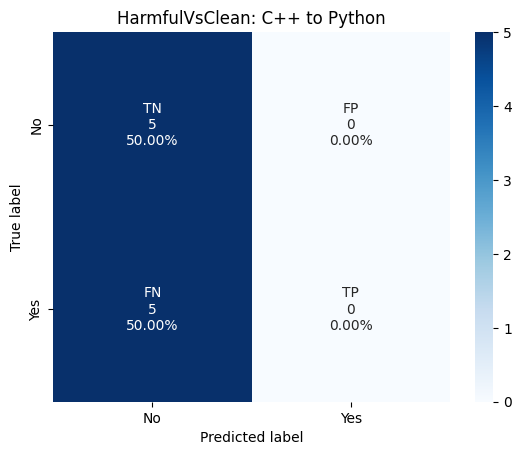

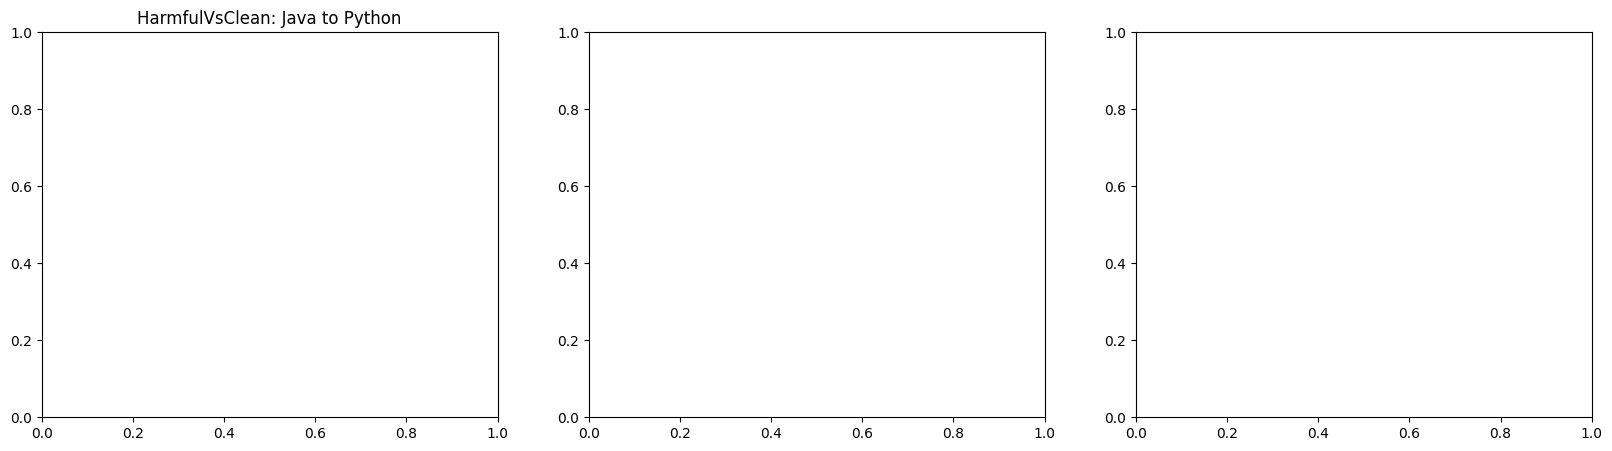

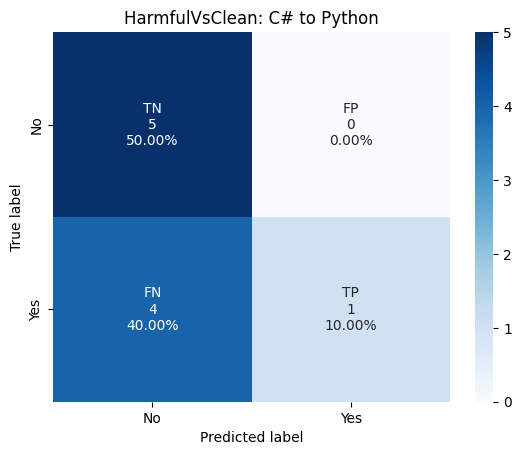

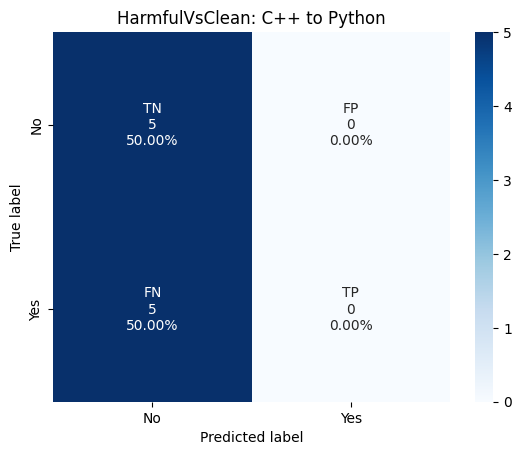

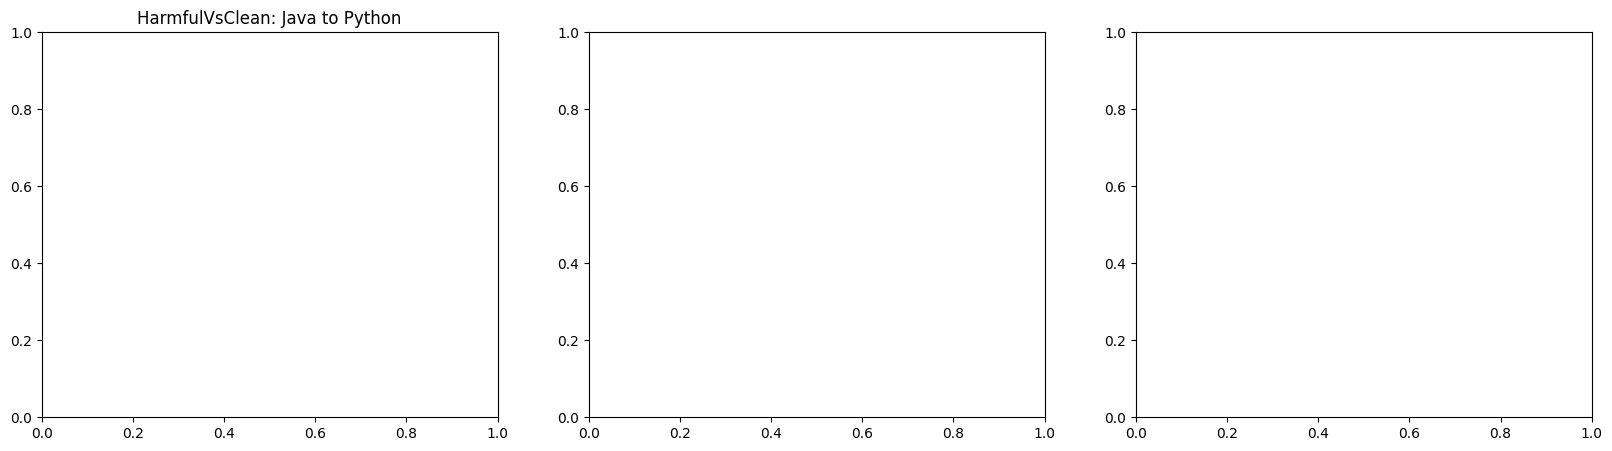

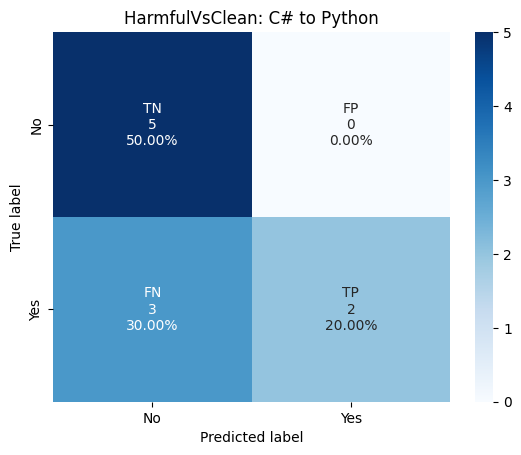

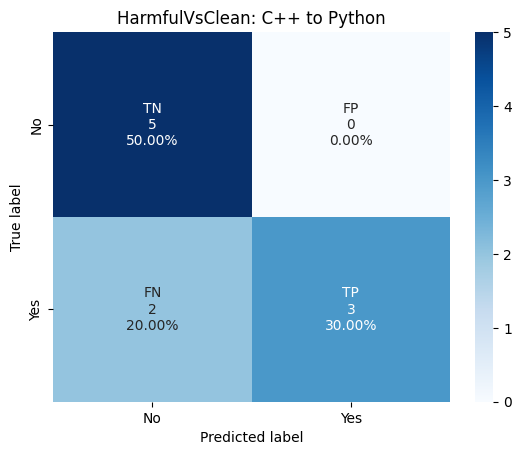

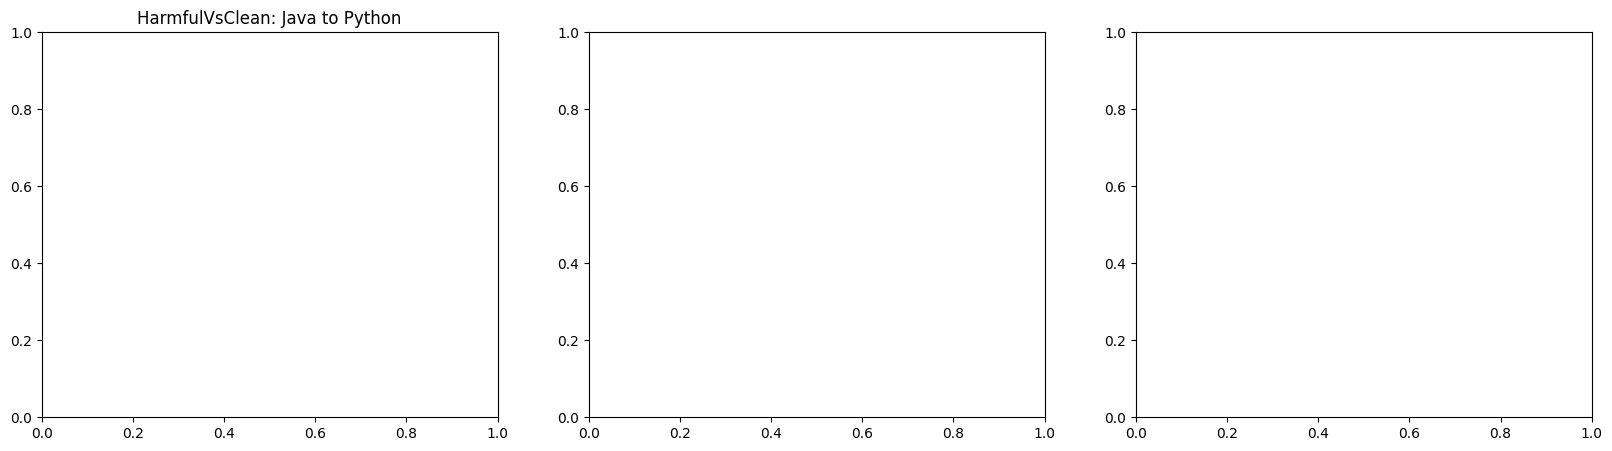

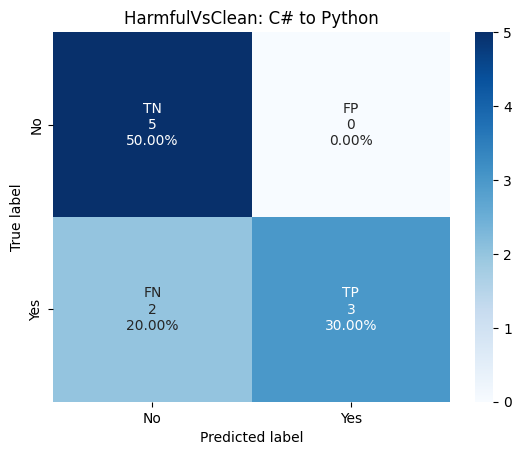

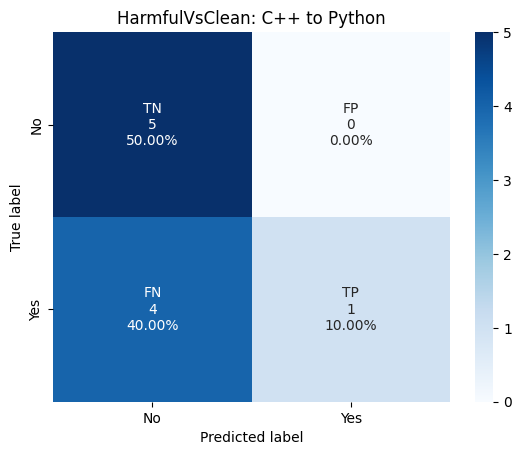

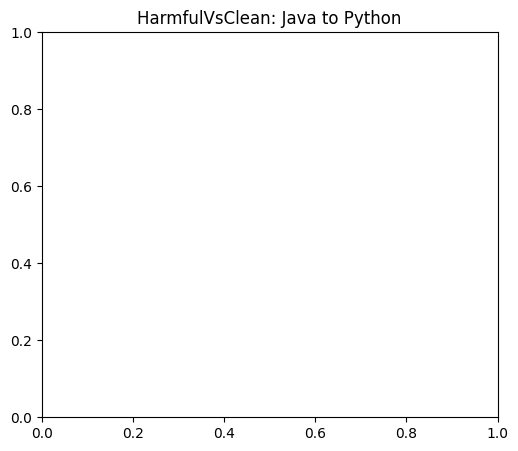

In [48]:
# result = transfer_learning_n_samples(['Python'], 'Java', 'Test_1', SMELLS[0], 'perceptron1')
results = []

for smell in SMELLS:
    for target_language in LANGUAGES:
        results.append(transfer_learning_n_samples(LANGUAGES, target_language, 'Test_1', smell, 'perceptron1'))

In [46]:
# Saving the results of those models when evaluated using Test datasets
for result in results:
    append_data_file(result)

# RQ4: How complex should the deep learning models be for effectively detecting code smells?

## Function

In [47]:
def cnn(padding):
    np.random.seed(RANDOM_STATE)
    model = Sequential()
    model.add(Embedding(20000, 8, input_length=padding))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

## Training CNN models

In [48]:
model_n_dict = {}
for smell in SMELLS:
    model_n_dict[smell['name']] = {}
    train_all_samples(LANGUAGES, 'Train_1', smell, cnn, 'cnn1', model_n_dict)

training model: Java HarmfulVsClean Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Java_cnn1_152_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_cnn1_152_hc/assets


training model: C# HarmfulVsClean Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C#_cnn1_106_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_cnn1_106_hc/assets


training model: C++ HarmfulVsClean Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C++_cnn1_96_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_cnn1_96_hc/assets


training model: Python HarmfulVsClean Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Python_cnn1_100_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_cnn1_100_hc/assets


In [52]:
# train_n_samples(['Python'], [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', SMELLS[0], cnn, 'cnn1')

for smell in SMELLS:
    train_n_samples(LANGUAGES, [2, 4, 8, 16, 32, 64, 128, 256], 'Train_1', smell, cnn, 'cnn1')

training model (n samples): Java HarmfulVsClean 4 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Java_cnn1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_cnn1_4_hc/assets


training model (n samples): Java HarmfulVsClean 8 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Java_cnn1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_cnn1_8_hc/assets


training model (n samples): Java HarmfulVsClean 16 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Java_cnn1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_cnn1_16_hc/assets


training model (n samples): Java HarmfulVsClean 32 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Java_cnn1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_cnn1_32_hc/assets


training model (n samples): Java HarmfulVsClean 64 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Java_cnn1_64_hc/assets


INFO:tensorflow:Assets written to: content/models/Java_cnn1_64_hc/assets


training model (n samples): Java HarmfulVsClean 128 Train_1 cnn1
Sample size too small, skipping
training model (n samples): Java HarmfulVsClean 256 Train_1 cnn1
Sample size too small, skipping
training model (n samples): Java HarmfulVsClean 512 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 4 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C#_cnn1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_cnn1_4_hc/assets


training model (n samples): C# HarmfulVsClean 8 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C#_cnn1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_cnn1_8_hc/assets


training model (n samples): C# HarmfulVsClean 16 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C#_cnn1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_cnn1_16_hc/assets


training model (n samples): C# HarmfulVsClean 32 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C#_cnn1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/C#_cnn1_32_hc/assets


training model (n samples): C# HarmfulVsClean 64 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 128 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 256 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C# HarmfulVsClean 512 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 4 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C++_cnn1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_cnn1_4_hc/assets


training model (n samples): C++ HarmfulVsClean 8 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C++_cnn1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_cnn1_8_hc/assets


training model (n samples): C++ HarmfulVsClean 16 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C++_cnn1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_cnn1_16_hc/assets


training model (n samples): C++ HarmfulVsClean 32 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/C++_cnn1_32_hc/assets


INFO:tensorflow:Assets written to: content/models/C++_cnn1_32_hc/assets


training model (n samples): C++ HarmfulVsClean 64 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 128 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 256 Train_1 cnn1
Sample size too small, skipping
training model (n samples): C++ HarmfulVsClean 512 Train_1 cnn1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 4 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Python_cnn1_4_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_cnn1_4_hc/assets


training model (n samples): Python HarmfulVsClean 8 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Python_cnn1_8_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_cnn1_8_hc/assets


training model (n samples): Python HarmfulVsClean 16 Train_1 cnn1
INFO:tensorflow:Assets written to: content/models/Python_cnn1_16_hc/assets


INFO:tensorflow:Assets written to: content/models/Python_cnn1_16_hc/assets


training model (n samples): Python HarmfulVsClean 64 Train_1 cnn1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 128 Train_1 cnn1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 256 Train_1 cnn1
Sample size too small, skipping
training model (n samples): Python HarmfulVsClean 512 Train_1 cnn1
Sample size too small, skipping


## Transfer Learning

transfer learning (n samples): ['Java', 'C#', 'C++', 'Python'] Java HarmfulVsClean
loading model: Java_cnn1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 7ms/step
loading model: C#_cnn1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 9ms/step
loading model: C++_cnn1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 8ms/step
loading model: Python_cnn1_4_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 8ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 8ms/step
loading model: C#_cnn1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 8ms/step
loading model: C++_cnn1_8_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==========================

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


2/2 [==============================] - 0s 10ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 9ms/step
loading model: C#_cnn1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 11ms/step
loading model: C++_cnn1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 10ms/step
loading model: Python_cnn1_16_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 8ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_32_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 10ms/step
loading model: C#_cnn1_32_hc, dataset_id: Java_HarmfulVsClean_Test_1.csv
2/2 [==============================] - 0s 10ms/step
loading model: C++_cnn1_32_hc, dataset_id: Java_HarmfulVsCl

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 68ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_16_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 66ms/step
loading model: C#_cnn1_16_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv


/home/easy/projects/transfer_learning/jserd_harmful_code_transfer_learning/content/cf_matrix.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


1/1 [==============================] - 0s 63ms/step
loading model: C++_cnn1_16_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 68ms/step
loading model: Python_cnn1_16_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 66ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 64ms/step
loading model: C#_cnn1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 63ms/step
loading model: C++_cnn1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 66ms/step
loading model: Python_cnn1_32_hc, dataset_id: C#_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 64ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_64_hc, dataset_id: C#_HarmfulVsClean_Test

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 62ms/step
loading model: C++_cnn1_4_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 64ms/step
loading model: Python_cnn1_4_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 57ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 59ms/step
loading model: C#_cnn1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 69ms/step
loading model: C++_cnn1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 58ms/step
loading model: Python_cnn1_8_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 58ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 58ms/step
loading model: C#_cnn1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 59ms/step
loading model: C++_cnn1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 58ms/step
loading model: Python_cnn1_16_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 58ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_32_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 60ms/step
loading model: C#_cnn1_32_hc, dataset_id: C++_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 54ms/step
loading model: C++_cnn1_32_hc, dataset_id: C++_HarmfulVsClean_T

/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 48ms/step
loading model: C++_cnn1_4_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 45ms/step
loading model: Python_cnn1_4_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 48ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 46ms/step
loading model: C#_cnn1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 49ms/step
loading model: C++_cnn1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 47ms/step
loading model: Python_cnn1_8_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv


/tmp/ipykernel_2816152/2542695009.py:112: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


1/1 [==============================] - 0s 47ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 49ms/step
loading model: C#_cnn1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 48ms/step
loading model: C++_cnn1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 48ms/step
loading model: Python_cnn1_16_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 47ms/step
num must be an integer with 1 <= num <= 3, not 4
Fail to build MF
loading model: Java_cnn1_32_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 47ms/step
loading model: C#_cnn1_32_hc, dataset_id: Python_HarmfulVsClean_Test_1.csv
1/1 [==============================] - 0s 49ms/step
loading model: C++_cnn1_32_hc, dataset_id: Py

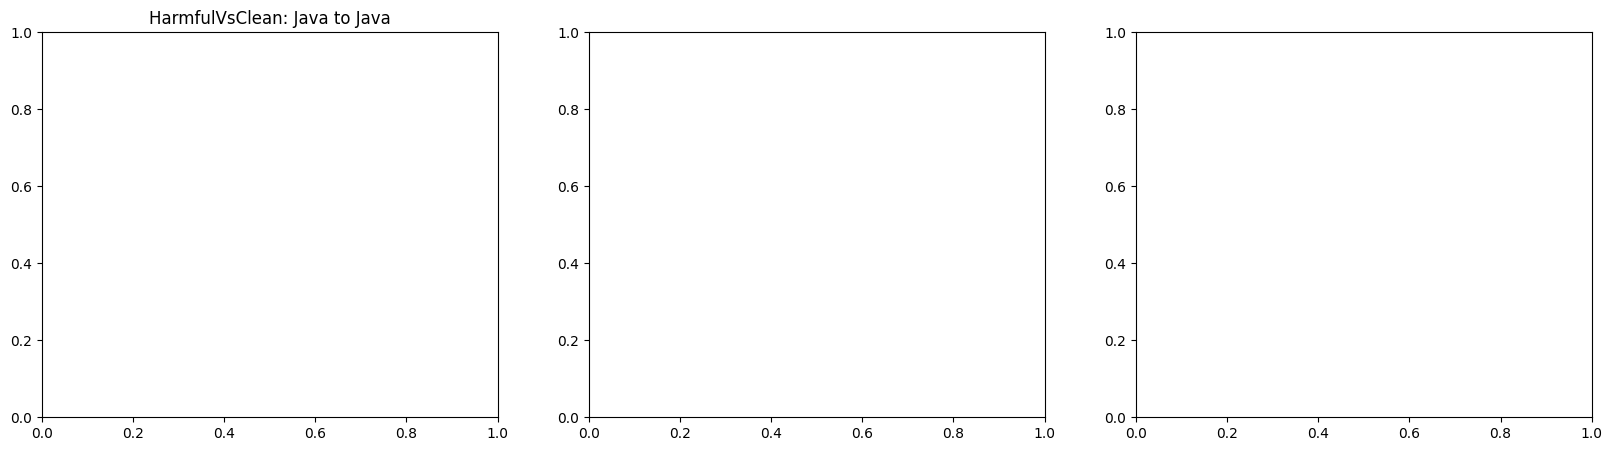

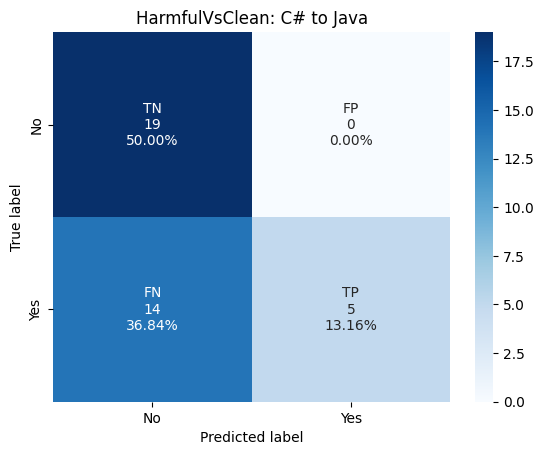

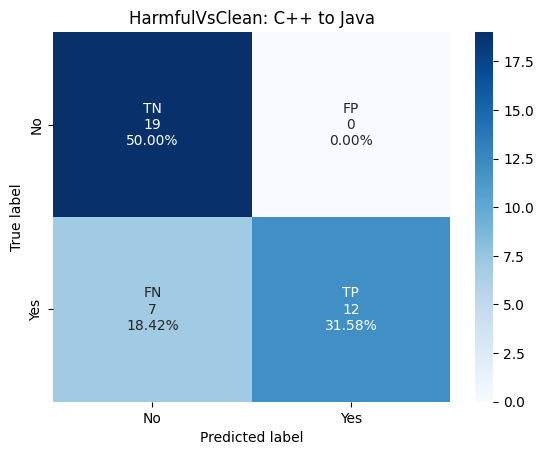

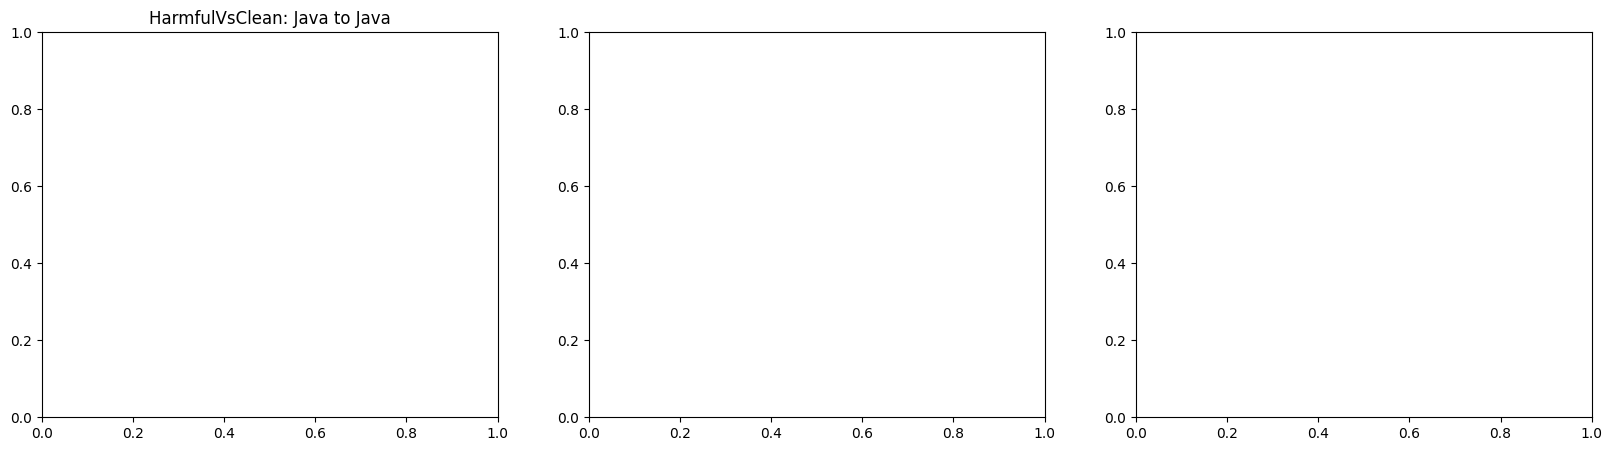

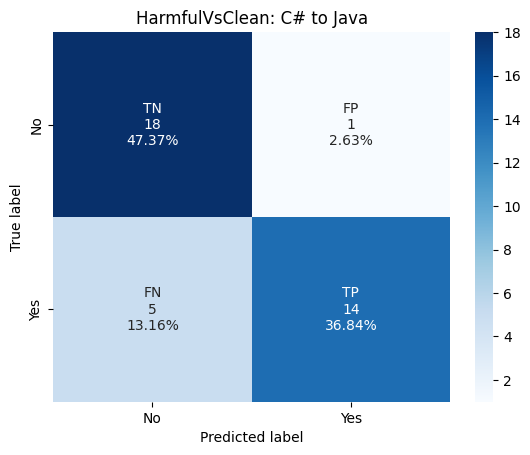

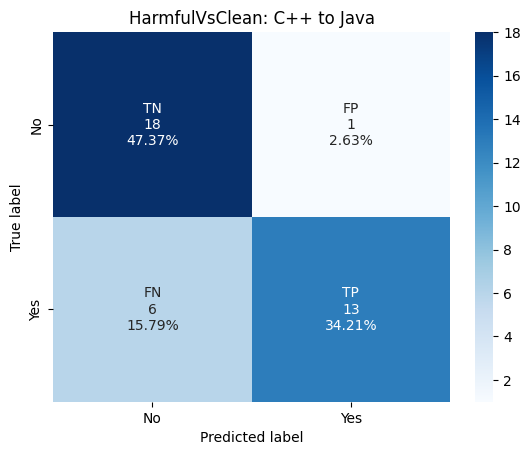

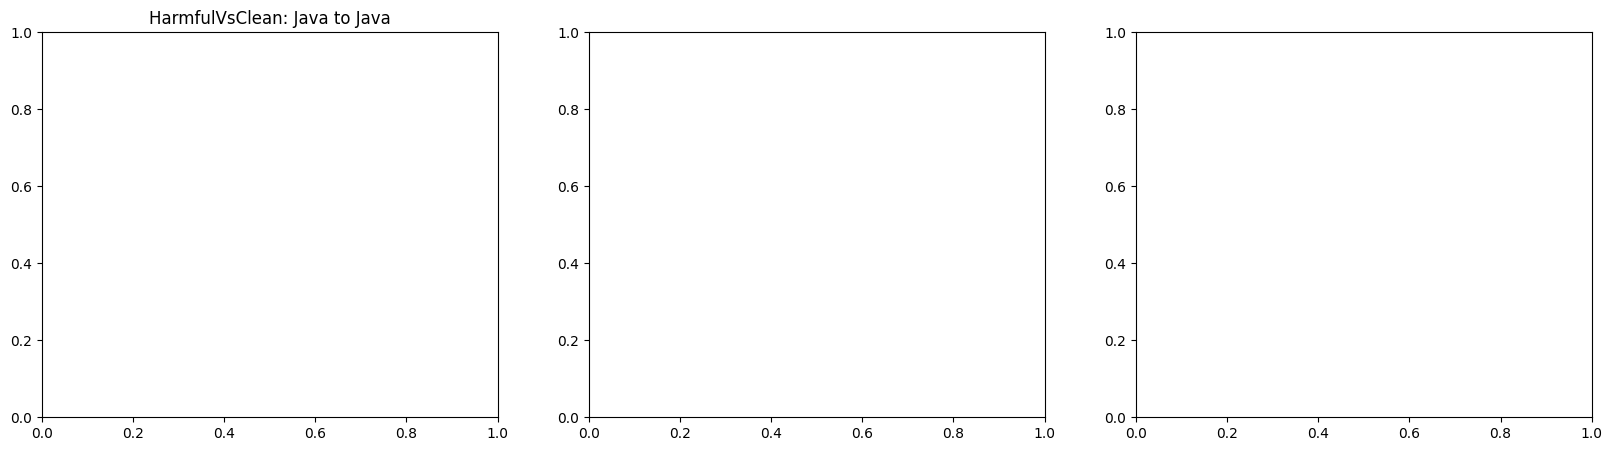

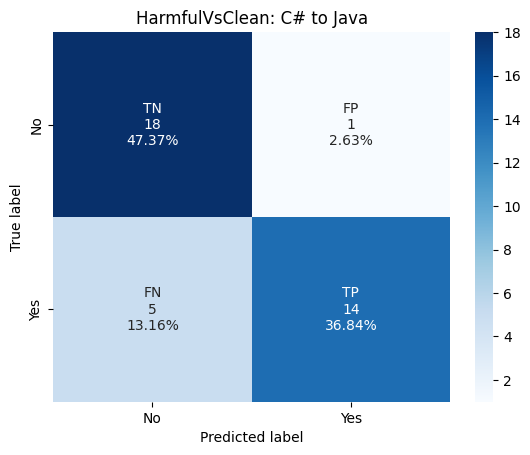

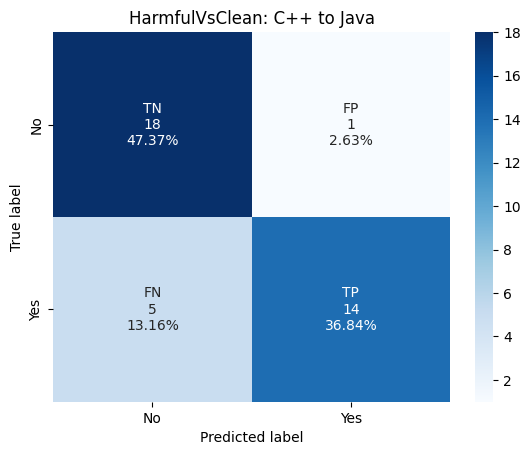

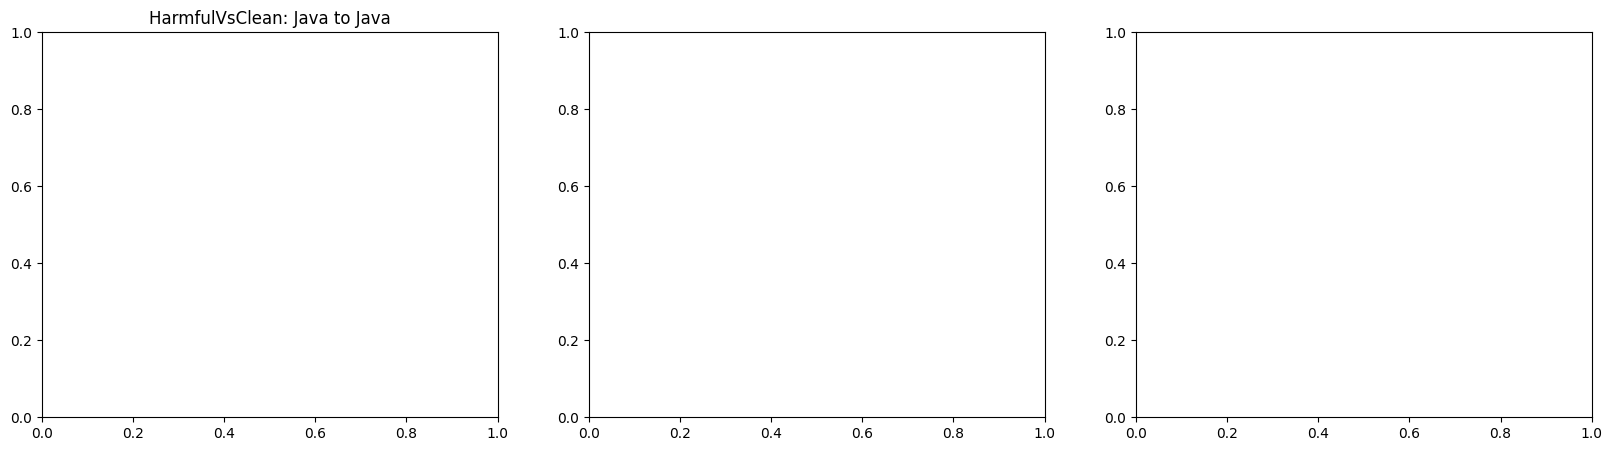

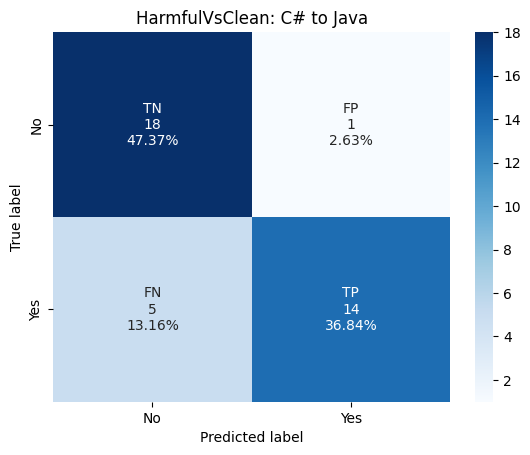

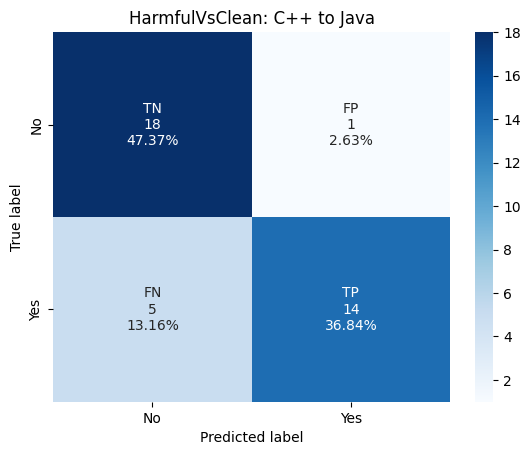

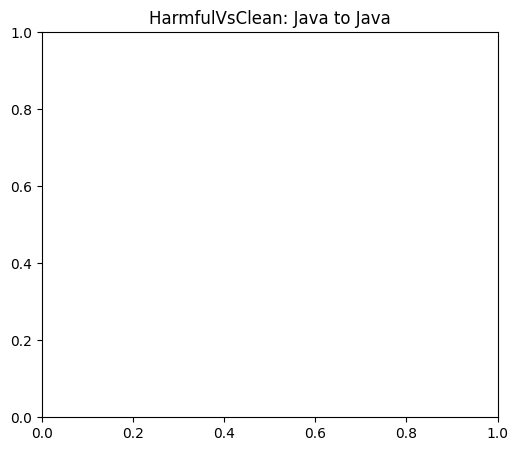

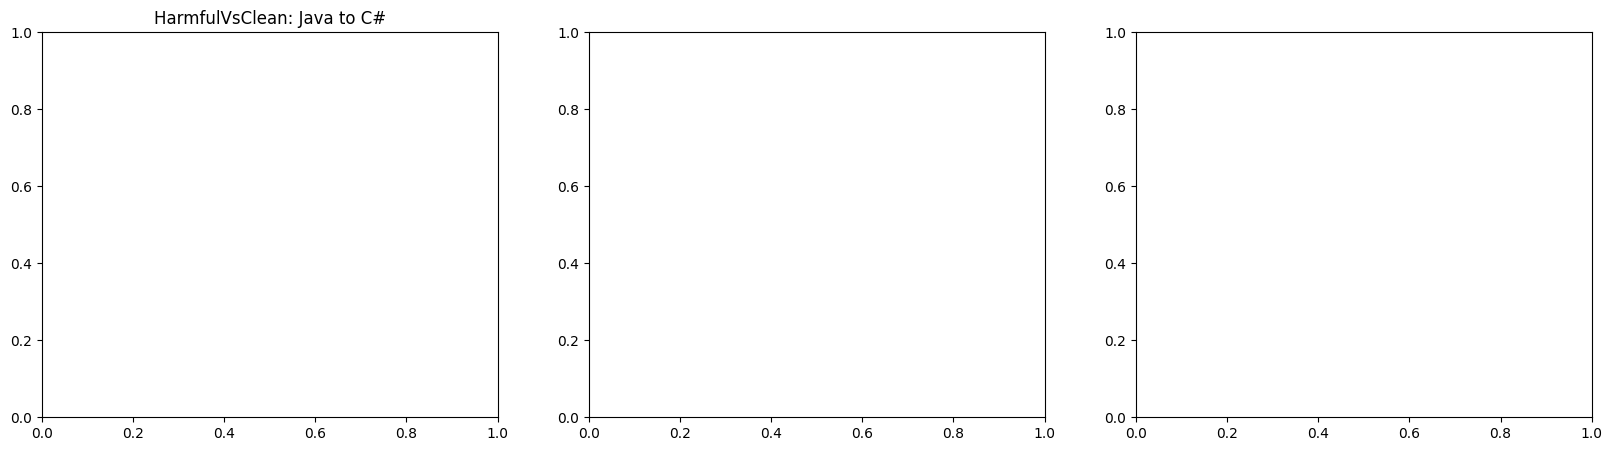

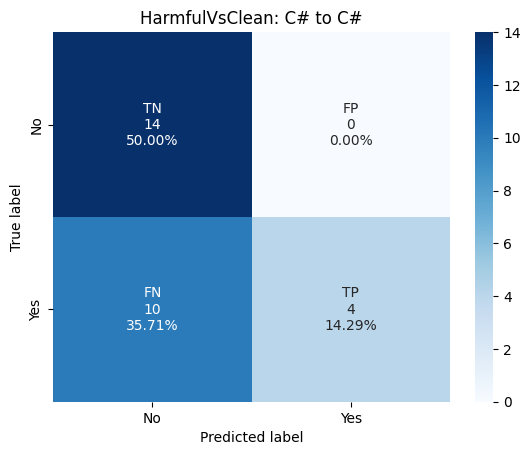

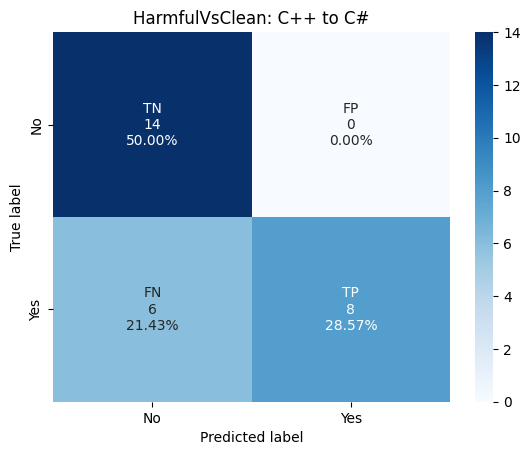

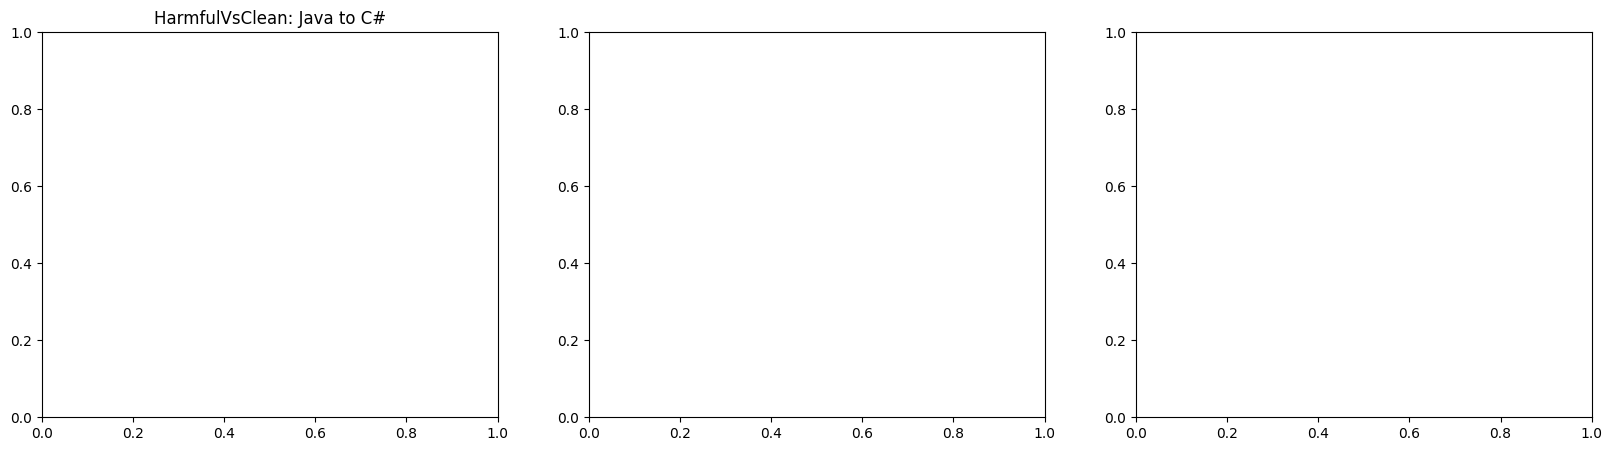

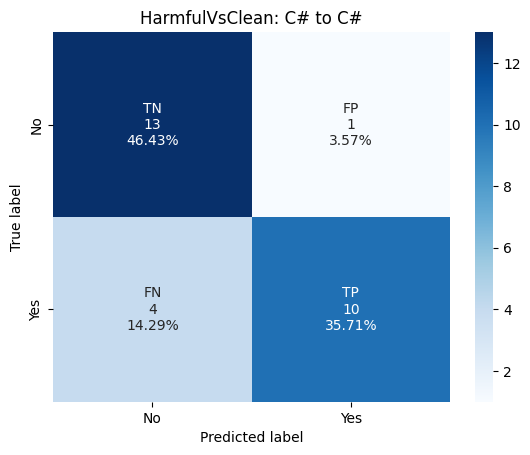

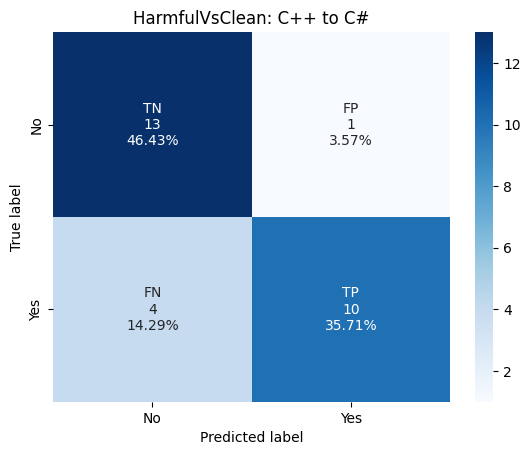

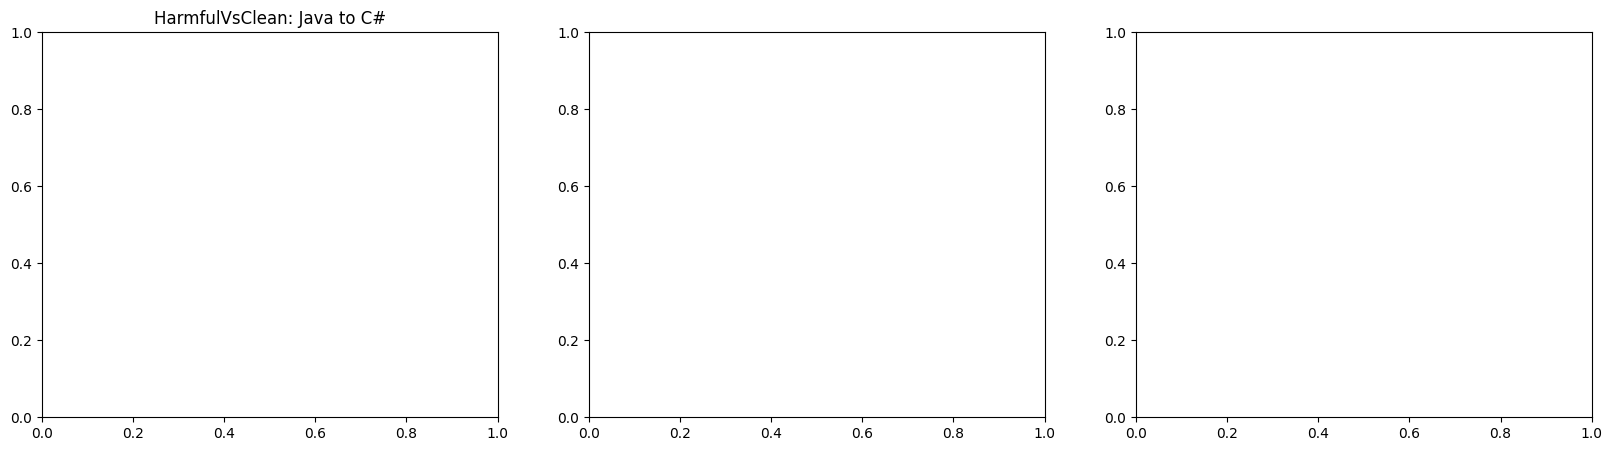

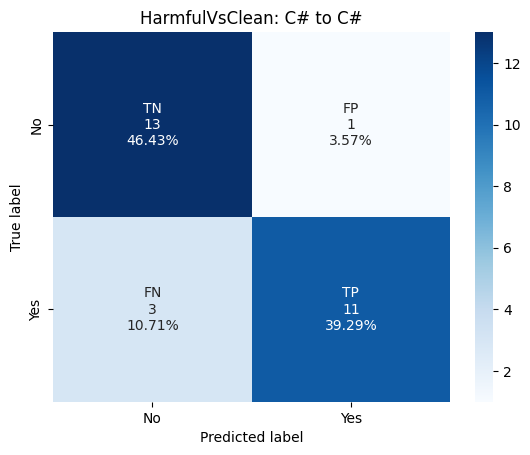

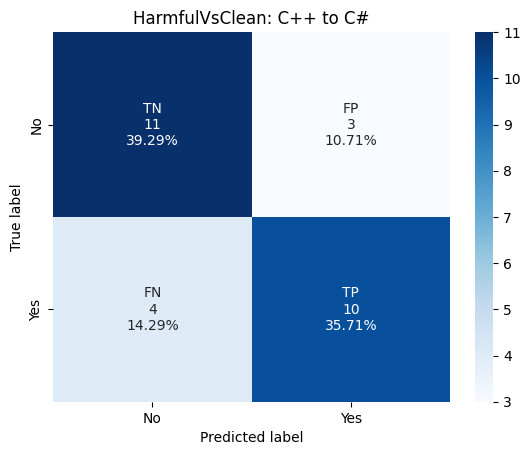

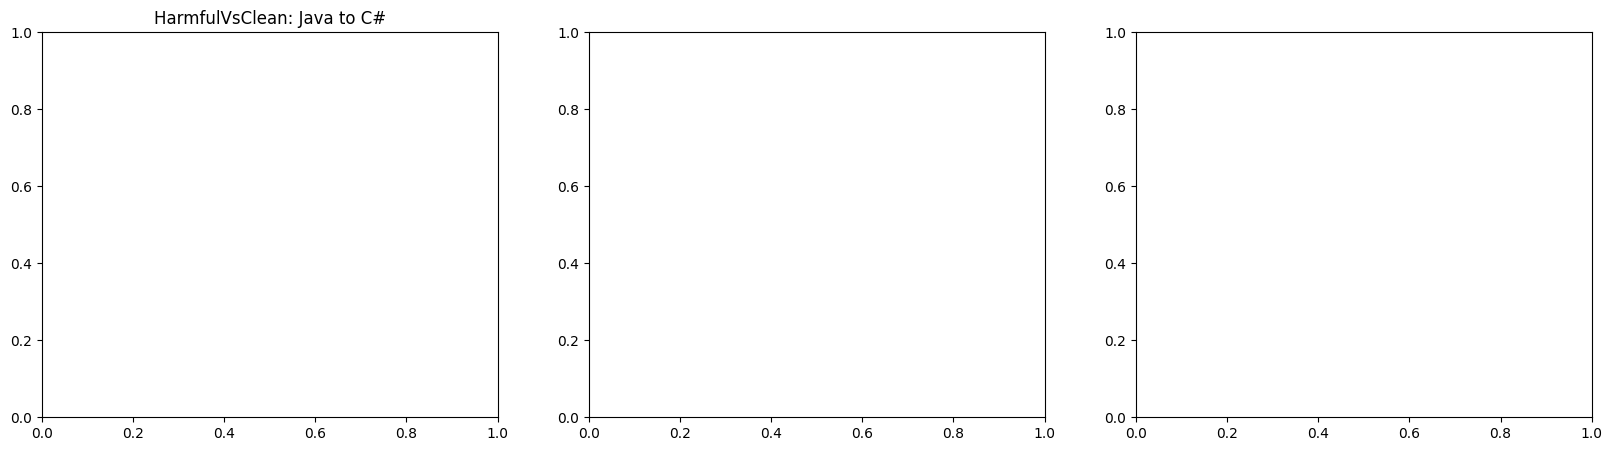

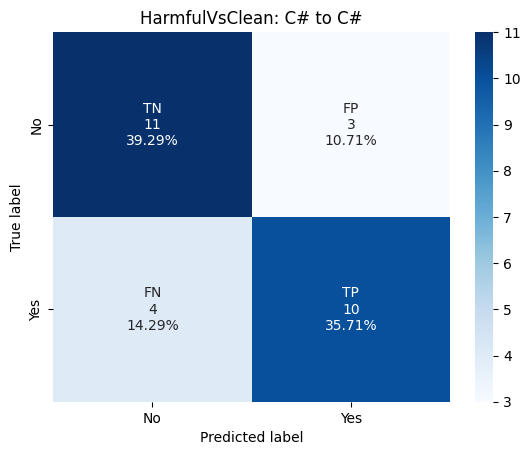

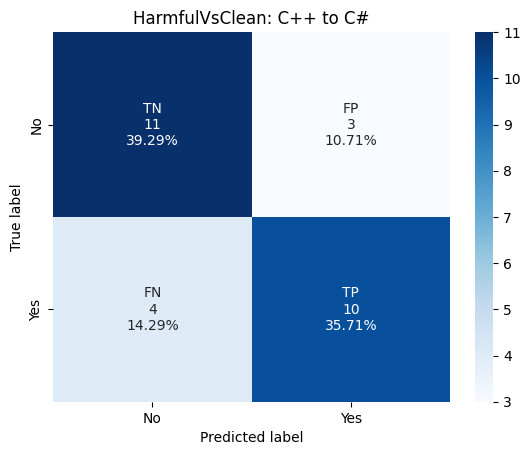

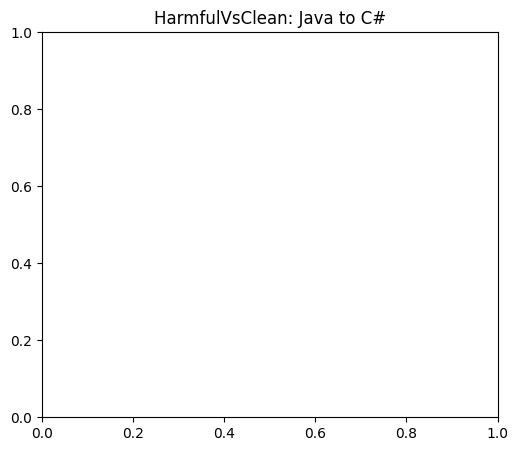

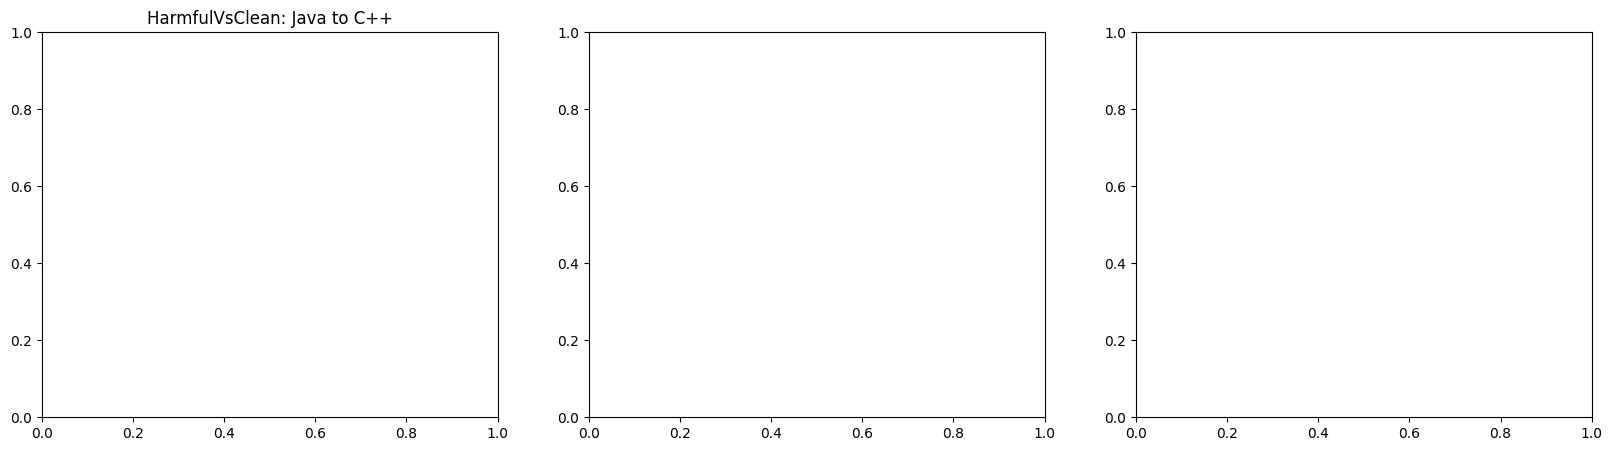

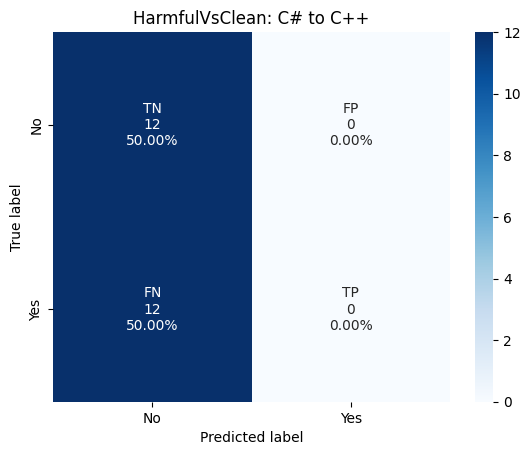

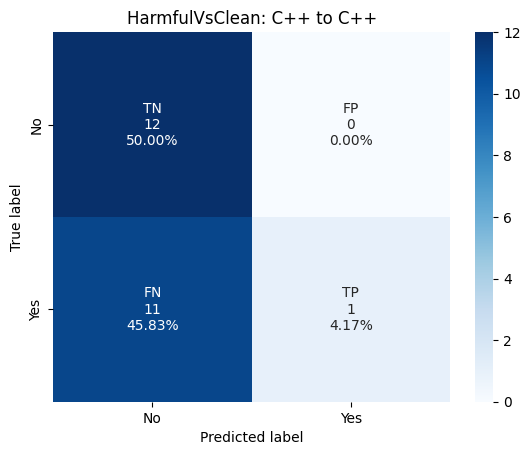

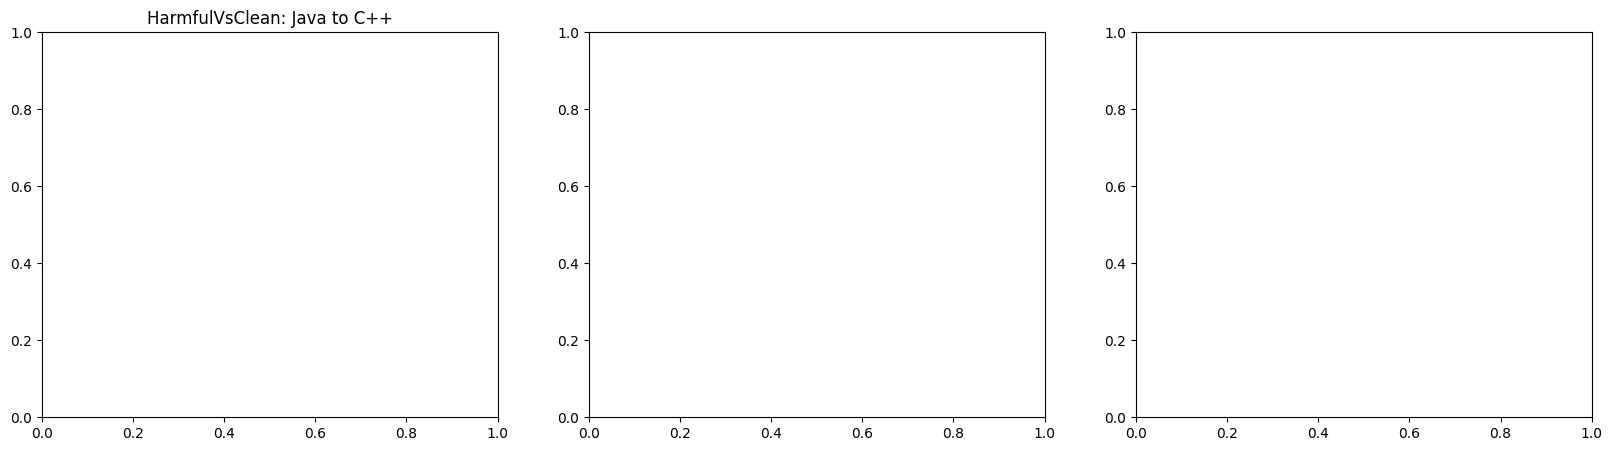

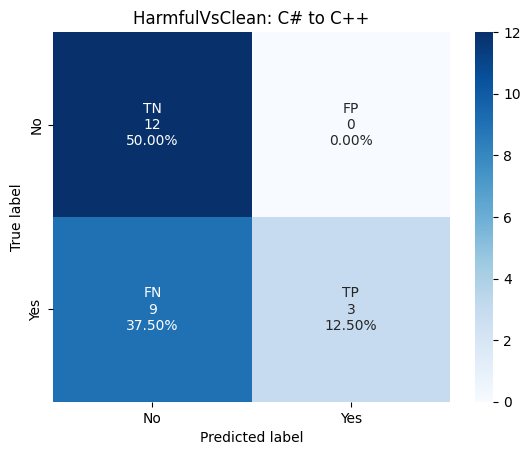

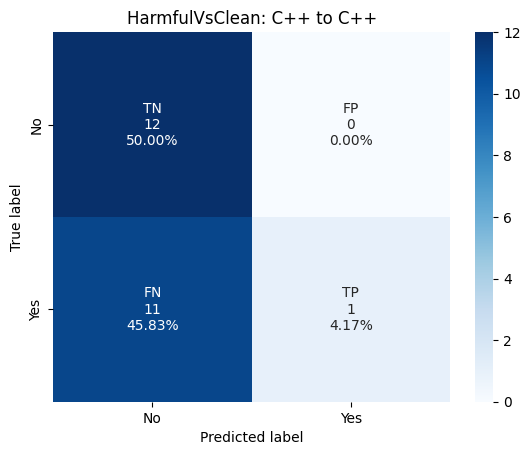

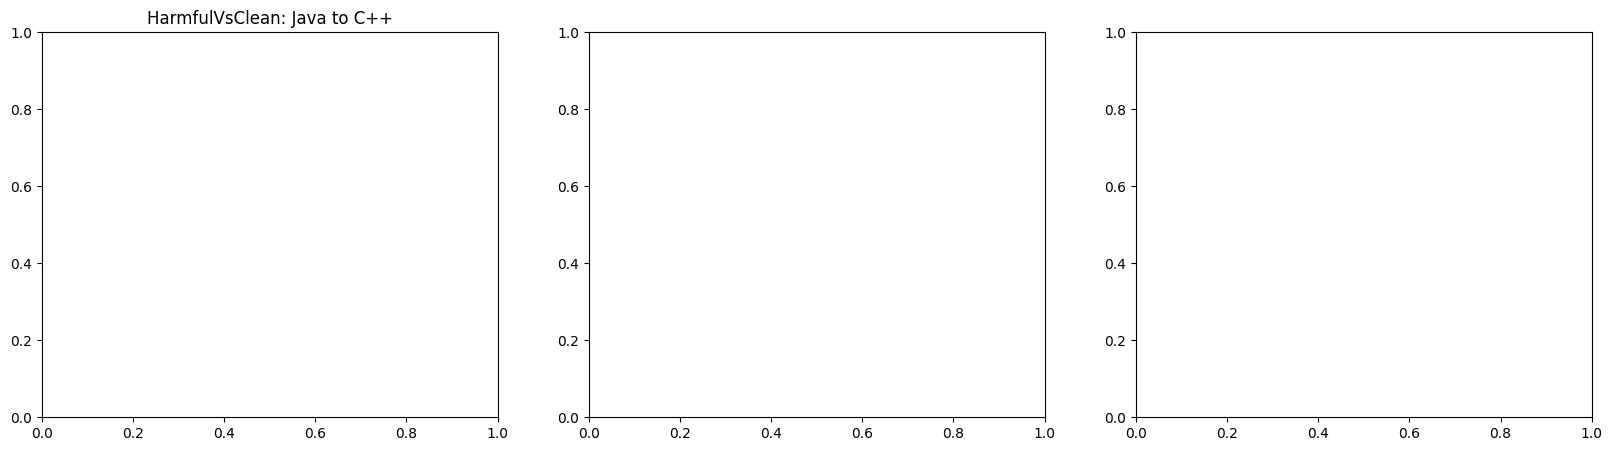

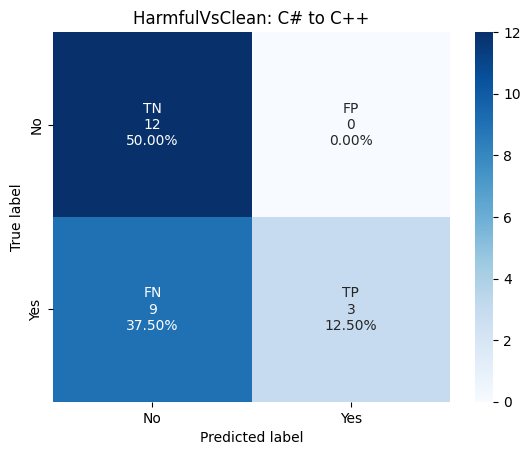

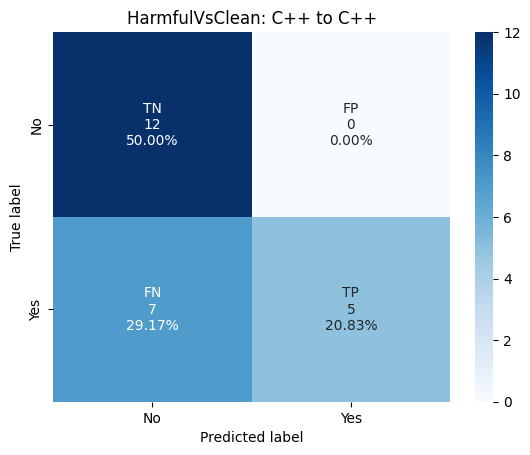

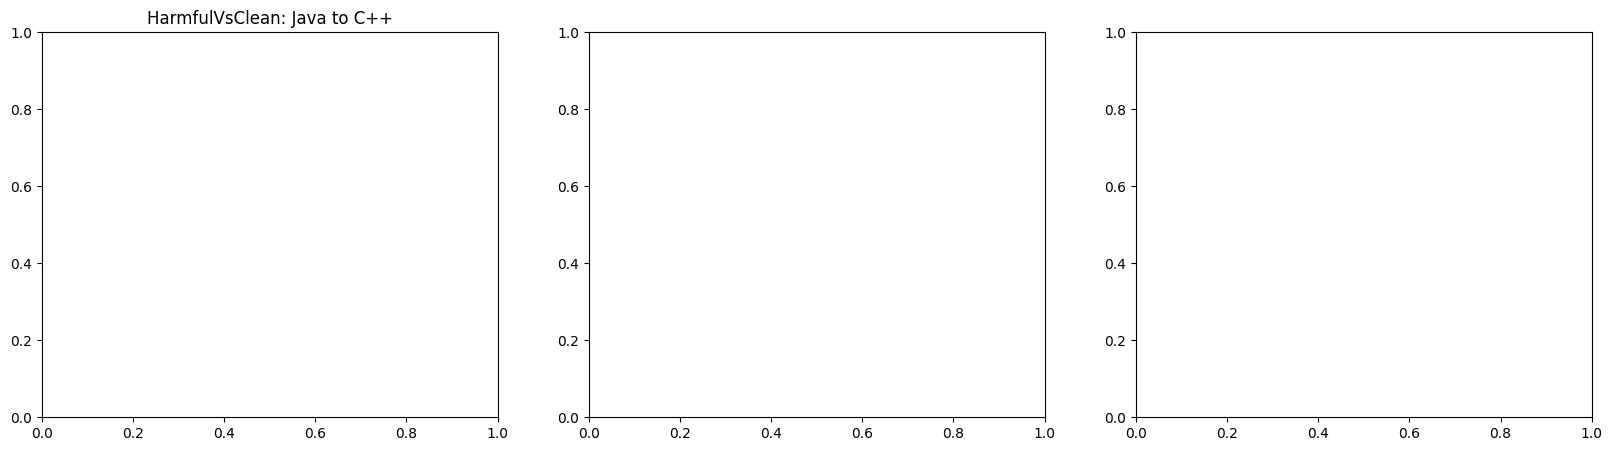

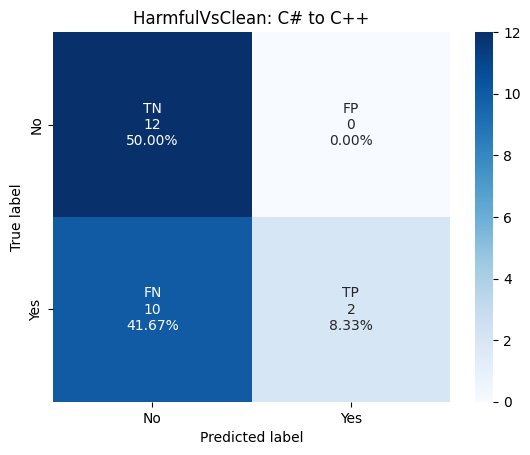

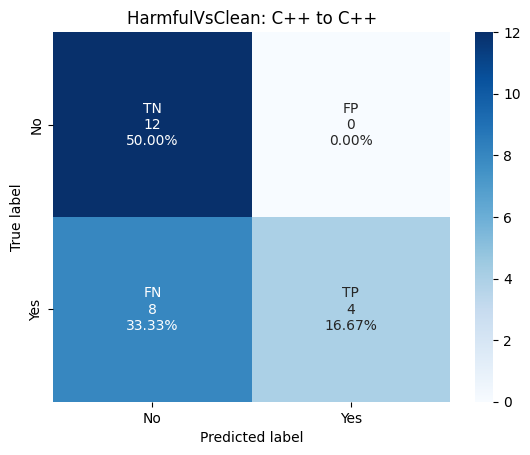

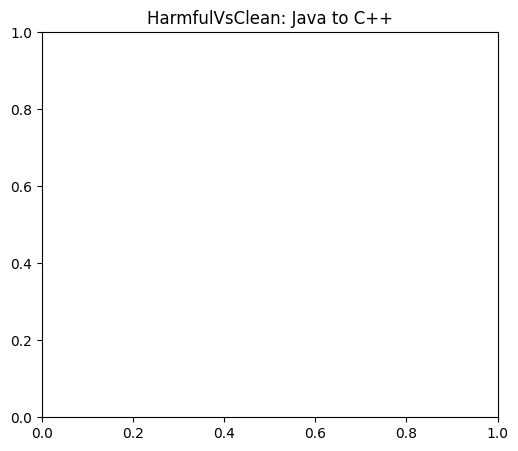

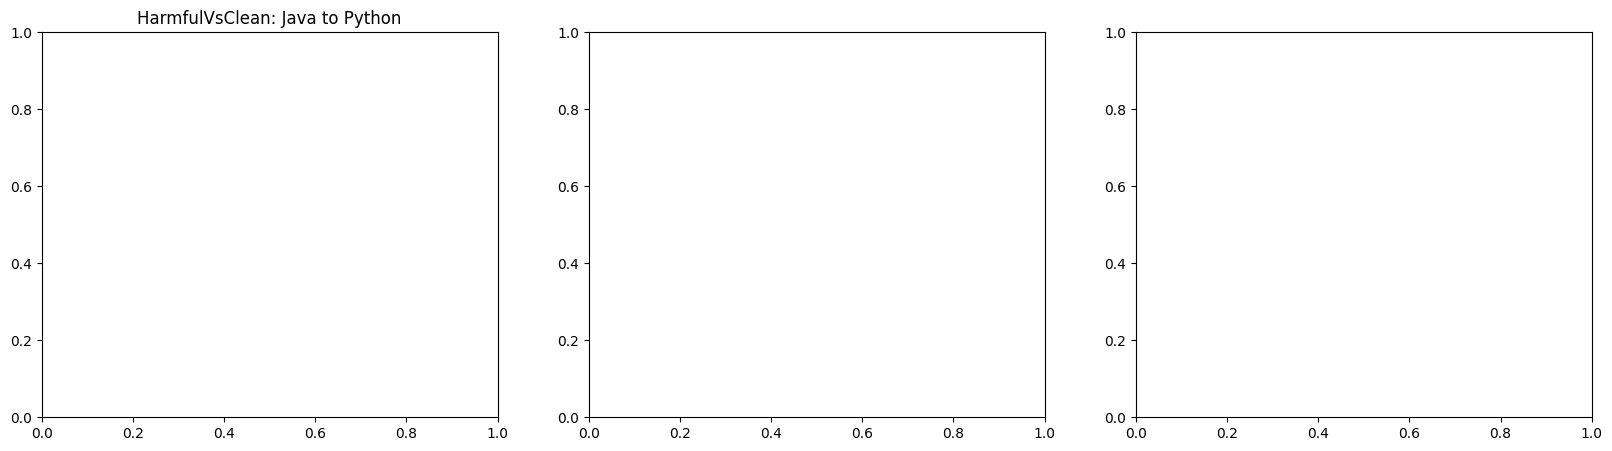

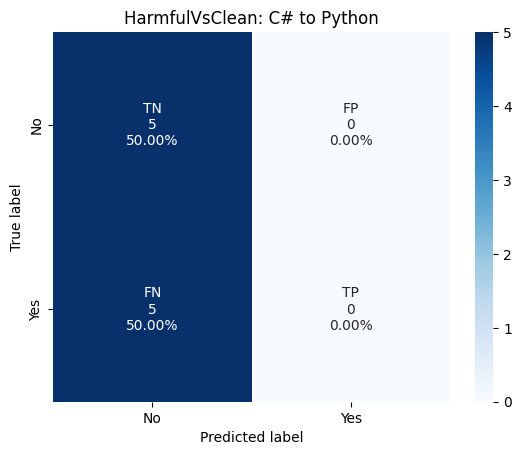

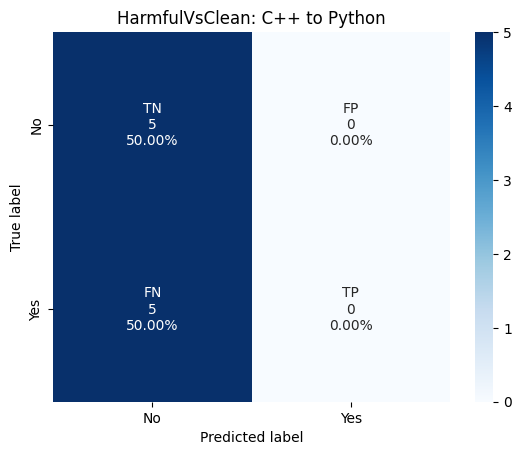

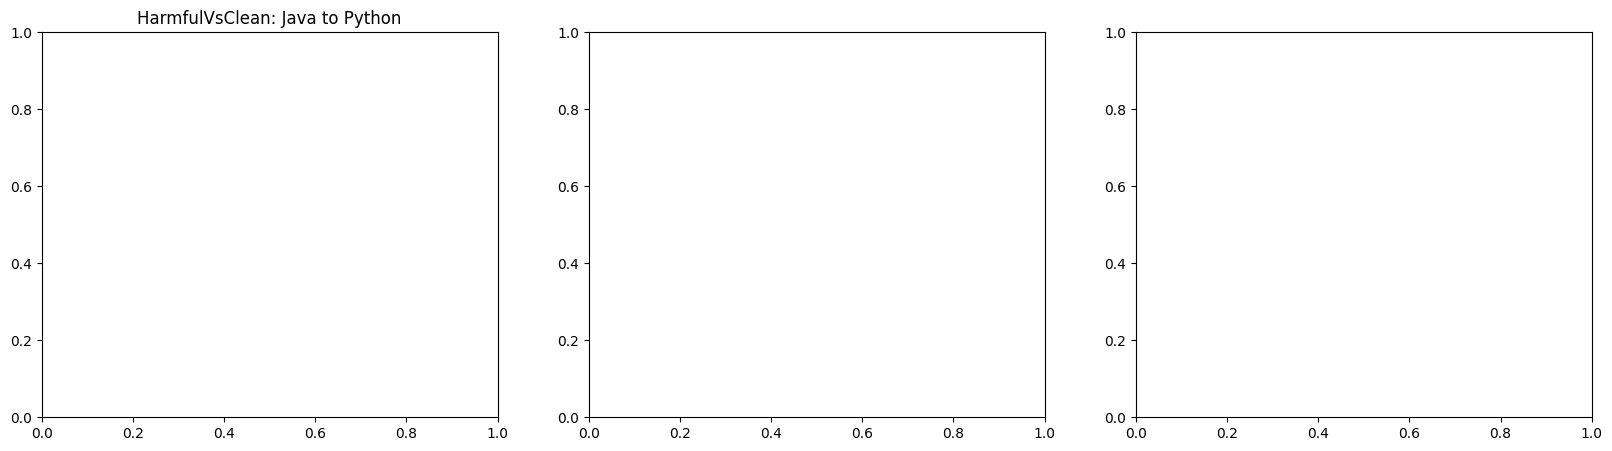

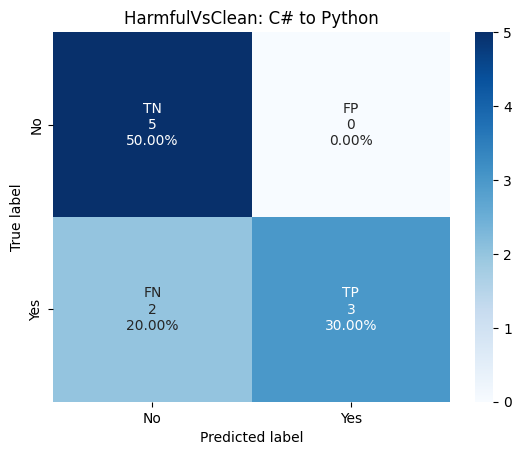

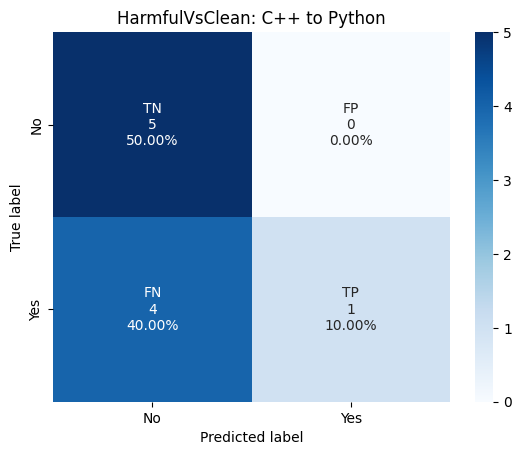

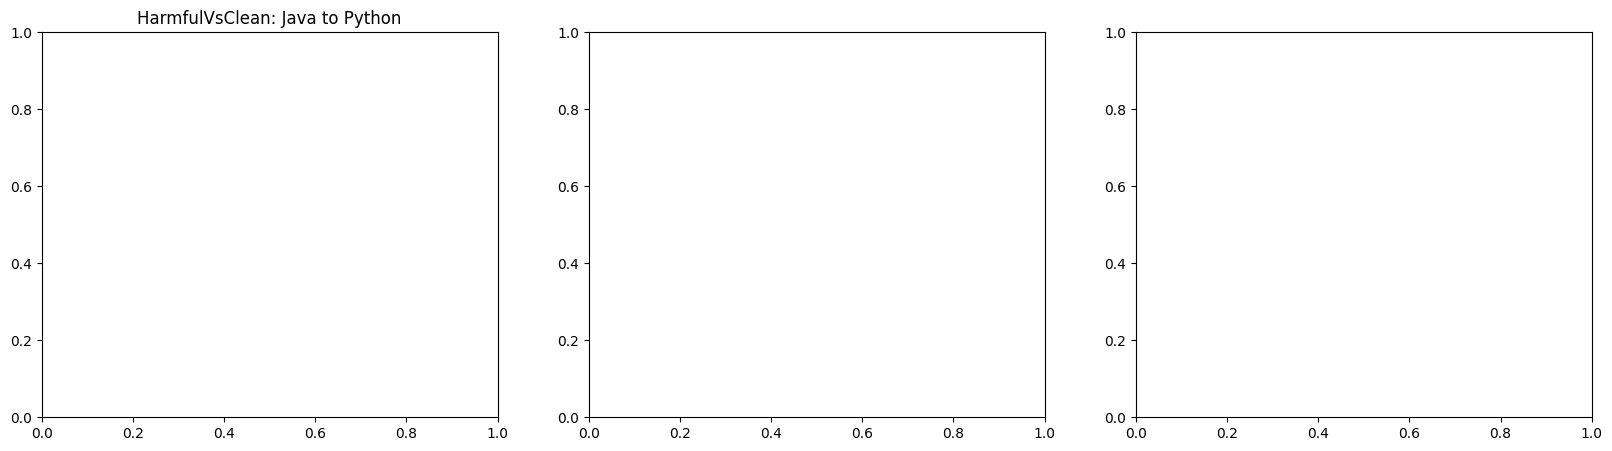

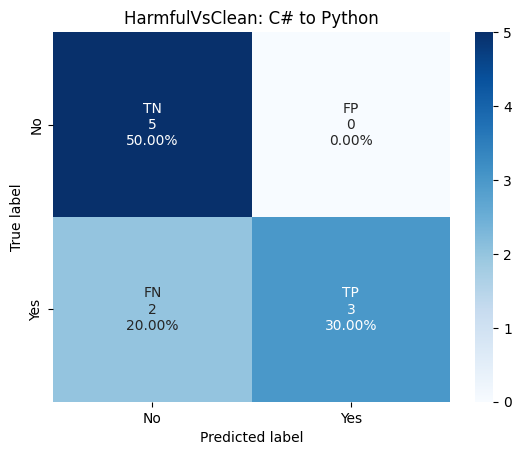

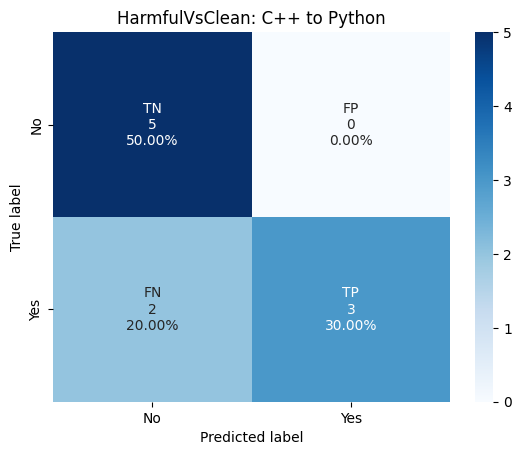

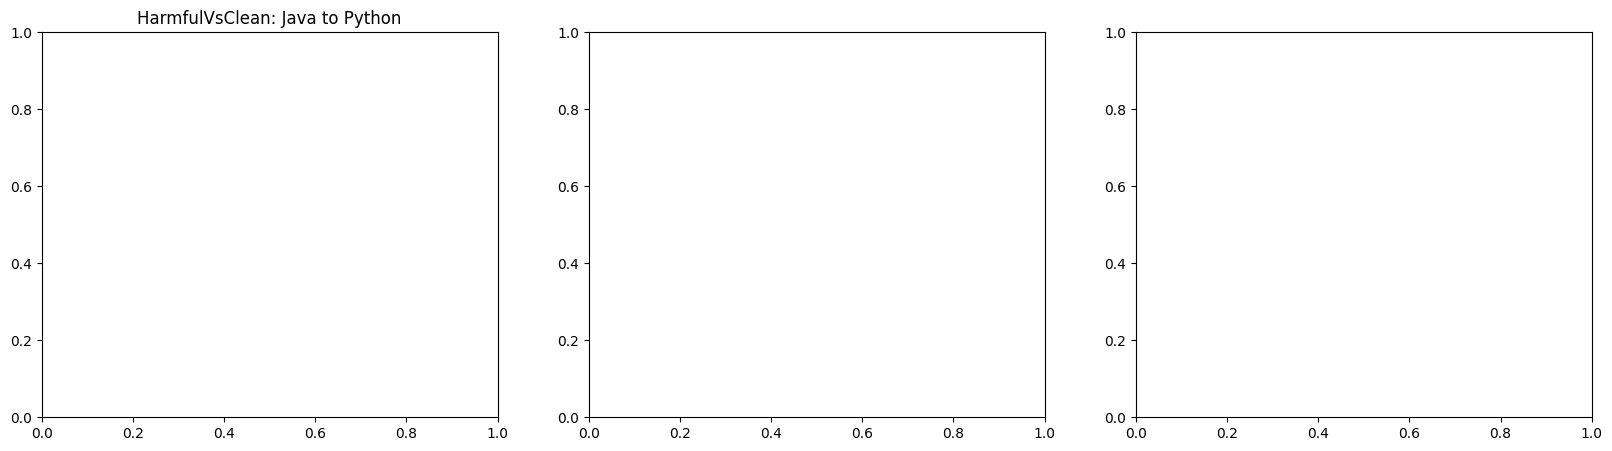

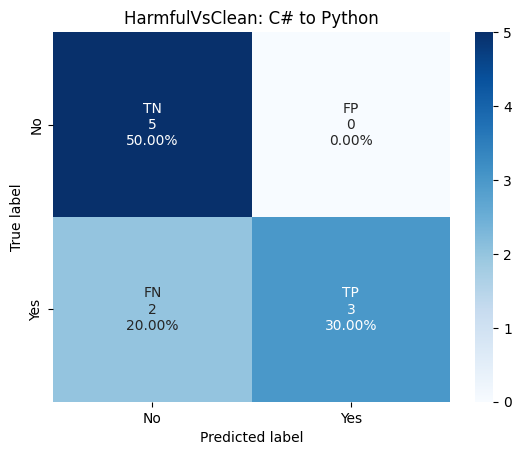

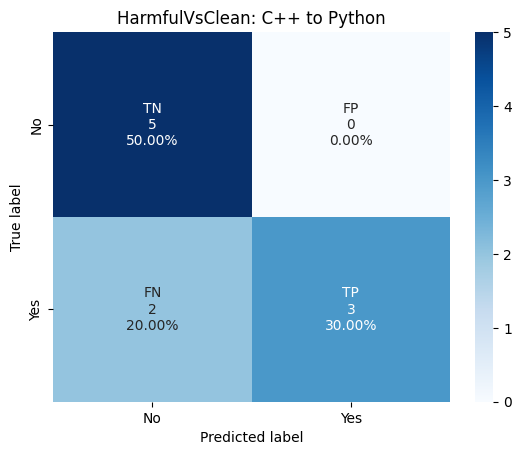

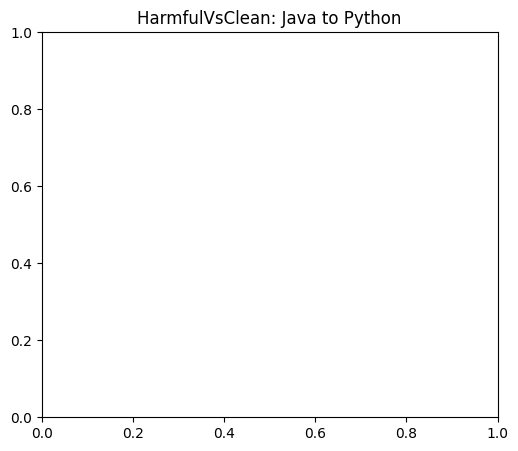

In [53]:
# result = transfer_learning_n_samples(['Python'], 'Java', 'Test_1', SMELLS[0], 'cnn1')

results = []

for smell in SMELLS:
    for target_language in LANGUAGES:
        results.append(transfer_learning_n_samples(LANGUAGES, target_language, 'Test_1', smell, 'cnn1'))

In [54]:
# Saving the results of those models when evaluated using Test datasets
# append_data_file(result)

for result in results:
    append_data_file(result)

# Save your files to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cp -av code_smells_datasets/ "/content/gdrive/MyDrive/Colab Notebooks/content"
%cp -av models/ "/content/gdrive/MyDrive/Colab Notebooks/content"
%cp -av results/ "/content/gdrive/MyDrive/Colab Notebooks/content"
%cp -av sample_data/ "/content/gdrive/MyDrive/Colab Notebooks/content"